# Summary: This notebook presents methods for extracting information from a CV. First we want to transform the document to HTML to get the rich tag data and formatting information to add a further dimension to text analysis.
# Then, we want to cut the document into sections, an XGBoost model works very well here and it's useful to identify where a new section begins and what type it is. 
# Having the sections it's relatively easy to design patterns that match the info we're looking for in each section. That said, some entity recognition is needed to extract universities, schools and companies (in the experience section). This notebook proposes a method to get entity candidates, and then check whether the google search snippets for each candidate are consistent with those of an entity or a different term. This method solves the underperfomance of the Named Entity Recognition tagger from the Stanford NLP package for spanish. It is likely that the sample on which the NER was trained (press reports) leaves the program at a loss when confronted to a CV context.

In [1]:
#Import packages
from bs4 import BeautifulSoup #for html processing
from os import listdir #for directory access
import os
from collections import defaultdict
from difflib import get_close_matches
import pandas as pd
import numpy as np
from distython import HEOM #Heterogeneous types (strings and numbers) distance metric
from sklearn.neighbors import NearestNeighbors
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt #for charts
import nltk #natural language toolkit
java_path = r'C:\Program Files (x86)\Java\jre1.8.0_241\bin\java.exe'
os.environ['JAVAHOME'] = java_path
from nltk.tag import StanfordPOSTagger #Part of Speech tagger
spanish_postagger = StanfordPOSTagger('C:\ProgramData\Anaconda3\StanfordModels\models\spanish.tagger', 'C:\ProgramData\Anaconda3\StanfordModels\stanford-postagger.jar')
import stanfordnlp

MODELS_DIR = './LangModel'
#stanfordnlp.download('es', MODELS_DIR) #activate to download spanish package for Stanford Natural Language Processing
nlp = stanfordnlp.Pipeline(lang='es',processors='tokenize,pos', models_dir=MODELS_DIR)

import re #regular expressions
import json
import unidecode
from nltk.lm import Vocabulary
from nltk.corpus import stopwords 

import xgboost as xgb #XGBoost
pd.options.display.max_columns = None
pd.set_option('display.max_rows', None)
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn import linear_model
from sklearn import metrics

from itertools import cycle

from gender_detector import gender_detector
detector = gender_detector.GenderDetector('ar') # It can also be ar, uk, uy.

from datetime import date
import json

#Stanford Name Entity Recognizer (NER), GNU general public license.
from nltk.tag import StanfordNERTagger
ser_path = r'C:\ProgramData\Anaconda3\StanfordCoreNLPSpanish\edu\stanford\nlp\models\ner\spanish.ancora.distsim.s512.crf.ser.gz'
jar = r'C:\ProgramData\Anaconda3\StanfordCoreNLPFull\stanford-corenlp-3.9.2.jar'
spanish_nertagger = StanfordNERTagger(ser_path,jar)

#Google custom search engine
import requests
import time
import csv

Use device: cpu
---
Loading: tokenize
With settings: 
{'model_path': './LangModel\\es_ancora_models\\es_ancora_tokenizer.pt', 'lang': 'es', 'shorthand': 'es_ancora', 'mode': 'predict'}
---
Loading: pos
With settings: 
{'model_path': './LangModel\\es_ancora_models\\es_ancora_tagger.pt', 'pretrain_path': './LangModel\\es_ancora_models\\es_ancora.pretrain.pt', 'lang': 'es', 'shorthand': 'es_ancora', 'mode': 'predict'}
Done loading processors!
---


In [2]:
#Reading CVs and cleaning constants
DATABASE_PATH = './curriculums/'
STRING = '.html'
UNNEEDED_TAGS = ['img', 'meta', 'script', 'style'] #These will be eliminated. 
ZERO_TOL_VALUE = 1e-6

In [3]:
#Database characteristics
filenames = listdir(DATABASE_PATH)
print('There are ',len(filenames),' in the database folder.')
d = defaultdict(int) #returns 0 if the key was not in the mapping.
for i in [x.split('.')[-1] for x in filenames]:
    d[i] += 1
print(d)

There are  101  in the database folder.
defaultdict(<class 'int'>, {'html': 50, 'pdf': 50, 'doc': 1})


In [4]:
#We're going to focus on html files
regex = re.compile(r'.html$')
html_files = list(filter(regex.search,filenames))

<!DOCTYPE html>
<!-- Created by pdf2htmlEX (https://github.com/coolwanglu/pdf2htmlex) -->
<html xmlns="http://www.w3.org/1999/xhtml">
 <head>
  <meta charset="utf-8"/>
  <meta content="pdf2htmlEX" name="generator"/>
  <meta content="IE=edge,chrome=1" http-equiv="X-UA-Compatible"/>
  <style type="text/css">
   /*! 
 * Base CSS for pdf2htmlEX
 * Copyright 2012,2013 Lu Wang <coolwanglu@gmail.com> 
 * https://github.com/coolwanglu/pdf2htmlEX/blob/master/share/LICENSE
 */#sidebar{position:absolute;top:0;left:0;bottom:0;width:250px;padding:0;margin:0;overflow:auto}#page-container{position:absolute;top:0;left:0;margin:0;padding:0;border:0}@media screen{#sidebar.opened+#page-container{left:250px}#page-container{bottom:0;right:0;overflow:auto}.loading-indicator{display:none}.loading-indicator.active{display:block;position:absolute;width:64px;height:64px;top:50%;left:50%;margin-top:-32px;margin-left:-32px}.loading-indicator img{position:absolute;top:0;left:0;bottom:0;right:0}}@media print{@page{
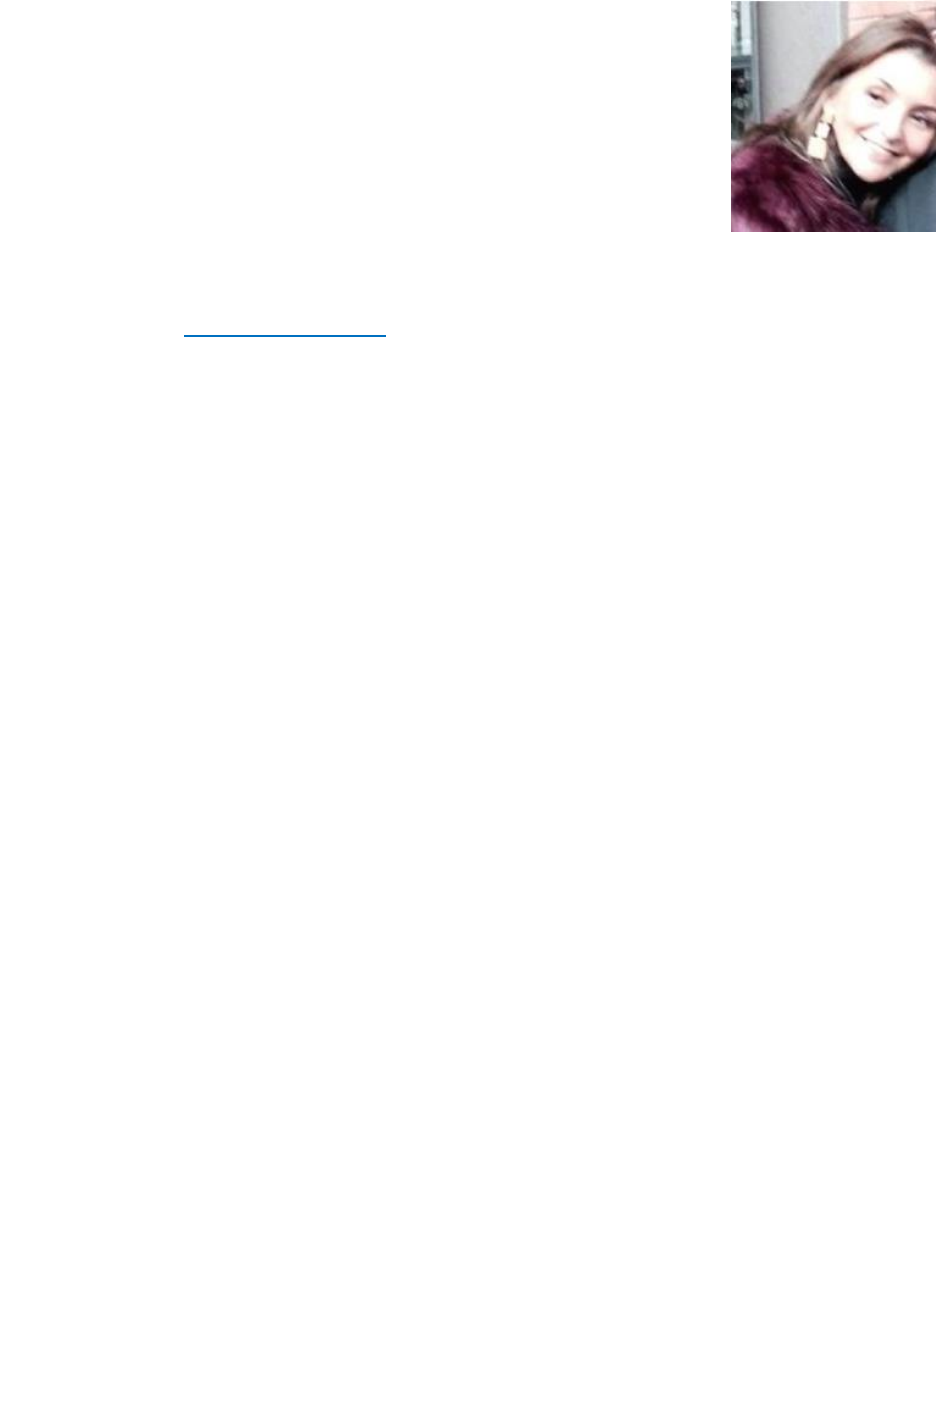
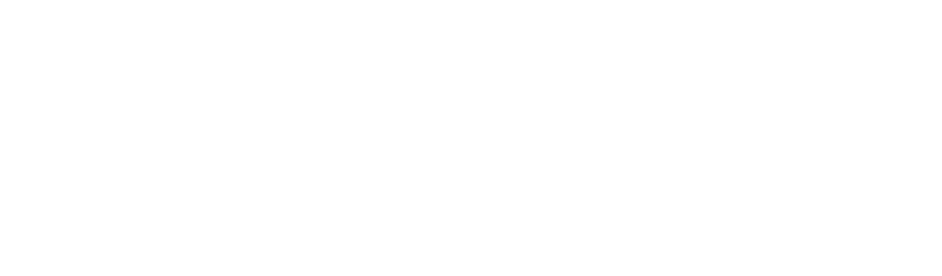
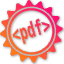

In [5]:
#This is how the first file looks like
with open(DATABASE_PATH + html_files[2],'rb') as f:
    soup = BeautifulSoup(f.read())
    
print(soup.prettify())

In [6]:
#Navigate the html document
#Set of tags
set([tag.name for tag in soup.find_all()])

{'a',
 'body',
 'div',
 'head',
 'html',
 'img',
 'meta',
 'script',
 'span',
 'style',
 'title'}

In [7]:
#We will map the classes later to the style. 
style = soup.find_all('style')
REGEX_CLASS = re.compile('\.\w+\{.+\}')
processed_style = re.findall(REGEX_CLASS,str(style))

### I don't need img, meta, script, nor style. But I need the classes from style. 

In [8]:
def clean_soup(s,tag_list_names):
    for t in tag_list_names:
        for match in s.find_all(t):
            match.decompose()
    return s

def get_classes(s,regex = REGEX_CLASS):
    style = soup.find_all('style')
    return re.findall(regex,str(style))

soup = clean_soup(soup,UNNEEDED_TAGS)

In [9]:
for tag in soup.body.find_all('div'):
    print(tag.attrs)
    for child in tag.descendants:
        print(str(type(child)))
        if str(type(child)) == "<class 'bs4.element.Tag'>":
            try:
                print(child.string.strip())
            except AttributeError: #'NoneType' object has no attribute 'strip'
                pass 
        if str(type(child)) == "<class 'bs4.element.NavigableString'>":
            print(child.string.strip().split(' '))

{'id': 'sidebar'}
<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.NavigableString'>
['']
{'id': 'outline'}
<class 'bs4.element.NavigableString'>
['']
{'id': 'page-container'}
<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>
<class 'bs4.element.Tag'>
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['Edith', 'C']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['Mellafe']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['Mi']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['randa']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['Cel:', '+']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['56', '9']
<class 'bs4.element.Tag'>
98995081
<class 'bs4.elem

<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['de']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['servi']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['ci']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['os.']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['Conozco']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['las']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['h']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['e']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['rramientas']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['d']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['e']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['g

<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['s']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.NavigableString'>
['Re']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['cu']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['rso']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['s']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.NavigableString'>
['de']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['la']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['Emp']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['re']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['sa)']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
[',']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.NavigableString'>
['sistemas']
<class 'bs

<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['2016']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['A']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['na']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['list']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['a']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['en']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['Cont']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['ro']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['l', 'd']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['e']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['gest']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['ión']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['Pa

<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['q']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['uiridos']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['o']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['impor']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['tados']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['desde']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['Francia', 'para', '', 'ser', 'distribu']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['id']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['os']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['y', 'po']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['s']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['terior']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['m']
<class 'bs4.element.Ta

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



['c']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['ur']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['se']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['de']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['c']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['ré']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['dit']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['o']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['en', 'e']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['l']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['s']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['is']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['tema']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['l']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['e'

<class 'bs4.element.NavigableString'>
['museos', 'y']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['centros', 'culturale']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['s).']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['Logro']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['e']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['l']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['10']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['0%']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['en']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['participació']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['n']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['en'

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.NavigableString'>
['a']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.NavigableString'>
['la']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.NavigableString'>
['m']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['arca']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['p']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['e']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['netraci']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['ón']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.NavigableString'>
['de', '', 'merca']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['d']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableSt

<class 'bs4.element.NavigableString'>
['pro']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['vee']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['dores']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['IN']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['CO']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['LUR']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.

['c']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['ión']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['.']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['Logro']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['e']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['l']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['10']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['0%']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['en']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['participaci']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['ón']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['en']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
[

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




['Pro']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['je']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['cts', 'S']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['ec']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['r']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['e']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['ta']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['ry']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['Ap']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['e']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['x']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['S']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['a']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['n']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['Cr'

<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.NavigableString'>
['Cri']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['stó']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['bal)']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
[',', '', 't']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['ra']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['sl']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['ados', '', 'y', '', 'h']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['o']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['spedaje']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['s', '', 'd']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['e']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'

<class 'bs4.element.NavigableString'>
['N']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['orma']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.NavigableString'>
['Chile']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['na']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.NavigableString'>
['p']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['a']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['ra']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.NavigableString'>
['la']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['imp']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['re']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['gnación', 'q']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['uímica', 'de', 'la']
<class 'bs4.e

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['L']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['a', 'Calera', 'Pl']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['a']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['nta']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['I']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['n']
<class 'bs4.element.Tag'>
<class 'b

<class 'bs4.element.NavigableString'>
['reuniones,']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.NavigableString'>
['rel']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['ación']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.NavigableString'>
['con']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.NavigableString'>
['p']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['ro']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['v']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['eedores,']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.NavigableString'>
['co']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['m']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['un']
<class 'bs4.element.Tag'>
<class 'bs4.element.Navigab

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.NavigableString'>
['Banco', 'BB']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['VA']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['Re']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['ali']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['z']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['ación', 'd']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['e']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['ev']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['entos']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<

<class 'bs4.element.NavigableString'>
['e']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['ro,']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['industria']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['l', 'y']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['comercia']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['l.']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['Pose']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['o']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['cono']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['cim']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['ie']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['ntos']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['par']
<class 'bs

<class 'bs4.element.NavigableString'>
['d']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['e']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['cisio']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['nes']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['d']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['e']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['la']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['especializa']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['ción.']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['T']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['engo']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['or']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['ientaci']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['ó']
<class 'bs4.ele

<class 'bs4.element.NavigableString'>
['s']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['os.']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.NavigableString'>
['E']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.NavigableString'>
['Business,']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.NavigableString'>
['CRM']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.NavigableString'>
['-']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.NavigableString'>
['Cu']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['sto']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['m']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['er']
<class 'bs4.element.T

<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['P']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['e']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['ug']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['eo']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['t']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['y']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['Citro']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['ë']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['n']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['consoli']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['da']
<class 'bs4.element.Tag'>
ndo
<class 'bs4.element.NavigableString'>
['ndo']
<cl

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['gu']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['imiento', 'perma']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['nente', 'de', 'cada', 'o']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['pera']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['ción']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['Re']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['ali']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['z']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['o', 'propuesta']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['s', 'd']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['e']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['mejo']
<class 'bs4.element.Ta

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['Ex']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['p']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['e']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['rie']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['ncia', 'e']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['n']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['grandes', '', 'em']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['presa']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['s', 'ex']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['tranjer']
<class 'bs4.element.Tag'>
<class 'bs4.element.Na

<class 'bs4.element.NavigableString'>
['ó']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['n,']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['d']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['e']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['softwa']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['re']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['aplicado']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['s']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['a']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['m']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['a']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['rketing,']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['entre']
<class 'bs4.element.Ta

<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['l']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['manejo']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.NavigableString'>
['de']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.NavigableString'>
['la']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.NavigableString'>
['documentació']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['n,']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.NavigableString'>
['co']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['nt']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['ro']
<class 'bs4.element.Tag'>
<class '

<class 'bs4.element.NavigableString'>
['Comerciale']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['s']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['Fijos']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.NavigableString'>
['y']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.NavigableString'>
['Variables']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['g']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['ene']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['ra']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['d']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['o']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['s']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['en']
<cla

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



['an']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['d']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['o.']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['Super']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['v']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['is']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['o', 'la']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['s']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['e']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['m']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['pre']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['sas', 'ex']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['t']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['erna']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableStr

['randa']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
{'class': ['t', 'm0', 'x0', 'h2', 'y3', 'ff1', 'fs3', 'fc0', 'sc0', 'ls0', 'ws0']}
<class 'bs4.element.NavigableString'>
['Cel:', '+']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['56', '9']
<class 'bs4.element.Tag'>
98995081
<class 'bs4.element.NavigableString'>
['98995081']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['/', 'e']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['dit']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['m']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['ellafe@hotmai']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['l.c']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['o']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['m']
<class 'bs4.element.Tag'>
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['/']
<class 'bs4.elem

<class 'bs4.element.NavigableString'>
['os.']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['Conozco']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['las']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['h']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['e']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['rramientas']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['d']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['e']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['']
{'class': ['t', 'm0', 'x0', 'h5', 'ya', 'ff1', 'fs4', 'fc0', 'sc0', 'ls0', 'ws0']}
<class 'bs4.element.NavigableString'>
['gestión']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['de']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['empresa']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['s']
<class 'bs4.element.Tag'>
<c

<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.NavigableString'>
['Re']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['cu']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['rso']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['s']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.NavigableString'>
['de']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['la']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['Emp']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['re']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['sa)']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
[',']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.NavigableString'>
['sistemas']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['p']
<class 'bs

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['20']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['15']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['-']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['2016']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
{'class': ['t', 'm0', 'x0', 'h4', 'y15', 'ff3', 'fs4', 'fc0', 'sc0', 'ls0', 'ws0']}
<class 'bs4.element.NavigableString'>
['A']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['na']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['list']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['a']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['en']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['Cont']
<class 'bs4.element.Tag'>
<class 'bs4.element.N

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




['ra']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['ci']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['on']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['es']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['']
{'class': ['t', 'm0', 'x0', 'h5', 'y2a', 'ff1', 'fs4', 'fc0', 'sc0', 'ls0', 'ws0']}
<class 'bs4.element.NavigableString'>
['Gestio']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['no', 'un']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['a']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['carte']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['ra', 'dia']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['ria']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['de', '11']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableStrin

<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['c']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['ré']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['dit']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['o']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['en', 'e']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['l']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['s']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['is']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['tema']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['l']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['e']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['gal']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['y']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['opera']
<

['obras', 'de', 'Arquitect']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['ura', 'e']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['m']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['blem']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['ática', 'como']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['museos', 'y']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['centros', 'culturale']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['s).']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['Logro']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['e']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['l']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['10']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['0%']
<cl

<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['.']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['En']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.NavigableString'>
['cuanto']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.NavigableString'>
['a']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.NavigableString'>
['la']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.NavigableString'>
['m']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['arca']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['p']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['e']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['netraci']
<class 'bs4.element.Tag'>
<class 'bs4.e

<class 'bs4.element.NavigableString'>
['diseñad']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['or']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['es']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['y']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['pro']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['vee']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['dores']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['IN']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['CO']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['LUR']
<class 'bs4.element.Tag'>
<c

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



<class 'bs4.element.NavigableString'>
['ES']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
[',']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['EN']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['AMI,', 'ANG']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['LO', 'AMERIC']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['A']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['N.']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['A']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['KER', 'KVA']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['E']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['R']
<class 'bs4.el

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['d']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['e']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['lici']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['tación']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['y']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['activ']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['idades']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['de']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['ev']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['aluación']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['técnica']
<class 'bs4.eleme

<class 'bs4.element.NavigableString'>
['a']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['ff']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['y']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['sus', 'asig']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['nacione']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['s', 'a', 'este']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['proye']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['cto.']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['Organizo']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.NavigableString'>
['lo']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['s']
<class 'bs4.element.Tag'>

<c

<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['orm']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['es']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['y']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.NavigableString'>
['cer']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['ti']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['fi']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['caciones']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.NavigableString'>
['del']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.NavigableString'>
['cu']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['mplimie']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['nto']
<cl

<class 'bs4.element.NavigableString'>
['de']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['los']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['ingeniero']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['s']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['en']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['la']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['t']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['o']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['m']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['a']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['de', 'm']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['uestras']
<class 'bs4.element.Tag

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['ra']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['s']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['Hidráulicas,']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['Hospitale']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['s,']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['Aero']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['p']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['uerto']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['s', 'y']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['obras', 'de', 'Arquitect']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['ura', 'e']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['m']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['blem']
<class 'bs4.element.Tag

<class 'bs4.element.NavigableString'>
['priv']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['ado', 'SICEP']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
[',', 'R']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['EGIC,', 'EN']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['PAP,', 'AGU']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['A']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['S']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['ANDIN']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['AS']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['etc']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['.']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['En']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']


<class 'bs4.element.NavigableString'>
['nt']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['a']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['ción', 'propuesta,']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['int']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['e']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['ractuan']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['d']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['o', 'co']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['n']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['diseñad']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['or']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['es']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['y']
<class 

['ons']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['tru']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['c']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['ción']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['me']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['c']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['ánica,', 'elé']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['c']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['trica']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['e', 'i']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['ns']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['t']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['rume']
<class 'bs4.element.Tag'>
<class 'bs4.element.Naviga

<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['pú']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['blico']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['(M']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['OP']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
[')']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['y']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['pri']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['v']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['ado']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['SICEP,', 'R']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['EGI']


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['isci']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['plinas', 'en', 'el', 'desa']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['rrol']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['lo', 'de', 'ingenie']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['ría', 'de', 'deta']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['lle']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['.']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['Elabor']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['o']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['y']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['m']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['a']
<class 'bs4.elemen

<class 'bs4.element.NavigableString'>
['t']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['o']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['m']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['a']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['de', 'm']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['uestras']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['qu']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['í']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['m']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['icas.']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>
<class

<class 'bs4.element.NavigableString'>
['nt']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['ro']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['l']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.NavigableString'>
['de']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.NavigableString'>
['docum']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['e']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['nt']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['o']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['s,']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.NavigableString'>
['coo']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['rdin']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['a']
<class 'bs4.element.Tag'>
<class 'bs4.el

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.NavigableString'>
['La']
<class 'bs4.element.Tag'>
<class 'bs4.element.Navig

<class 'bs4.element.NavigableString'>
['te']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.NavigableString'>
['la']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.NavigableString'>
['docum']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['e']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['n']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['ta']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['ción']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.NavigableString'>
['administrativ']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['a,']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.NavigableString'>
['legal']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.NavigableString'>
['y']
<class 'b

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



['c']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['trica']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['e', 'i']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['ns']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['t']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['rume']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['nta']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['c']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['ión']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['.']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['']
{'class': ['t', 'm0', 'x0', 'h5', 'y4d', 'ff1', 'fs4', 'fc0', 'sc0', 'ls0', 'ws0']}
<class 'bs4.element.NavigableString'>
['Logro']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['e']
<class 

<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
[')']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['y']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['pri']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['v']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['ado']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['']
{'class': ['t', 'm0', 'x0', 'h5', 'y51', 'ff1', 'fs4', 'fc0', 'sc0', 'ls0', 'ws0']}
<class 'bs4.element.NavigableString'>
['SICEP,', 'R']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['EGI']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['C']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
[',']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['EN']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['PAP,', 'AGU']
<class 

{'class': ['t', 'm0', 'x0', 'h7', 'y58', 'ff3', 'fs5', 'fc0', 'sc0', 'ls0', 'ws0']}
<class 'bs4.element.NavigableString'>
['A']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['KER', 'KVA']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['E']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['R']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['NER', 'ME']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['T']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['A']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['LS']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element

<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['y']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['activ']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['idades']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['de']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['ev']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['aluación']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['técnica']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['y']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['comerci']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['al']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['d']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['y']
{'class': ['t', 'm0', 'x0', 'h5', 'y62', 'ff1', 'fs4', 'fc0', 'sc0', 'ls0', 'ws0']}
<class 'bs4.element.NavigableString'>
['sus', 'asig']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['nacione']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['s', 'a', 'este']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['proye']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['cto.']
{'class': ['t', 'm0', 'x0', 'h5', 'y63', 'ff1', 'fs4', 'fc0', 'sc0', 'ls0', 'ws0']}
<class 'bs4.element.NavigableString'>
['Organizo']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.NavigableString'>
['lo']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['s']
<class 'bs4.element.Tag'>

<class 'bs4.element.Navigab

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['or']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['as']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.NavigableString'>
['en']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.NavigableString'>
['el']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.NavigableString'>
['p']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['ro']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['ceso']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.NavigableString'>
['pro']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['du']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['ctiv']
<class 'bs4.element.Tag'>
<class 'bs4.el

<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['s', 'p']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['la']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['ntas', '1', 'y']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['2']
<class 'bs4.element.Tag'>
.
<class 'bs4.element.NavigableString'>
['.']
<class 'bs4.element.NavigableString'>
['Apoy']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['o', 'al', 'ger']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['ente', 'de', 'Pro']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['du']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['cció']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['n', 'de', 'la']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>
<class 'bs4.element.Nav

['y', 'co']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['m']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['uni']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['cación', 'v']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['isual']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['A']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['p']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['titude']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['s', 'y', 'cono']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['cimi']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['entos:']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>
<class 'bs4

['L']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['e']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['s', 'A']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['ll']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['es']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['Ex']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['cel']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>

<class 'bs4.elem

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.NavigableString'>
['Dulongo']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>
{'class': ['pc', 'pc3', 'w0', 'h0']}
<class 'bs4.elem

<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['t']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['ing']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.NavigableString'>
['estra']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['t']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['égico,', '', 'Mar']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['keting']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.NavigableString'>
['Dire']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['ccional,', '', 'Marke']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['ting']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['Int']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['e']
<class 'bs4.elemen

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.NavigableString'>
['EFEwdw']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['ard']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['Gestión', 'Fi']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['n']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['a']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['nciera']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>

<class 'b

<class 'bs4.element.NavigableString'>
['201']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['1']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['']
{'class': ['t', 'm0', 'x0', 'h4', 'y7f', 'ff3', 'fs4', 'fc0', 'sc0', 'ls0', 'ws0']}
<class 'bs4.element.NavigableString'>
['Ingenierí']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['a', 'en', 'Ejecución']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['en', 'A']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['dm']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['inis']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['tración', 'd']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['e']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['Empres']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['as']
<cla

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.NavigableString'>
['Gestión']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.NavigableString'>
['de']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.NavigableString'>
['Ma']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['rca,']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['S']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['A']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['P,']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['m']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['odulo,']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.NavigableString'>


['nciera']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.Tag'>

<class 'bs4.element.NavigableString'>
['']
<class 'bs4.element.NavigableString'>
['Serco']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['t']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['e']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['c']
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>
['']
{'class': ['t', 'm0', 'x0', 'h5', 'y91', 'ff1', 'fs4', 'fc0', 'sc0', 'ls0', 'ws0']}
<class 'bs4.element.NavigableSt

### So far, we have been able to isolate all the elements we need for information extraction (in a single CV) inside the body. There are some undesirable behaviors such as strings being separated by tags inside the divisions. This has an easy fix:

In [10]:
def get_rich_tag_data(processed_style,l_atts):
    big_d = {}
    for att in l_atts:
        d = {}
        #if there is no match in the regular expression the resulting dictionary will have a single entry with the attribute.
        d['css_'+att] = [att]
        regex_str = '\.' + att + '\{.+\}'
        reg = re.compile(regex_str)
        for s in processed_style:
            match = re.match(reg,s)
            if match:
                d = {} #reset dictionary
                for bit in s.split('{')[1].replace('px','').split(';'):#get rid of the string before '{' and replace units (pixels) for nothing
                    if ':' in bit:
                        quarks = bit.split(':')
                        try:
                            d[quarks[0]] = [float(quarks[1])]
                        except ValueError:
                            d[quarks[0]] = [quarks[1]]
                break #just need the first match
        big_d = {**big_d, **d}
    return pd.DataFrame.from_dict(big_d)

In [11]:
FORMAT_FEATURES_SIZE = 11 #I counted them in the html, but this contant could change for a different pdf-to-html program.
first_run = True
counter = 1
for tag in soup.body.find_all('div'):
    change_in_format = 0
    s = ''
    list0 = []
    list1 = []
    for child in tag.descendants:
        if child.name == 'span' and (child.string != None and len(child.string.strip())>0): #there will be a change in format.
            change_in_format = 1
            list0 = child.attrs['class']
            print('span info: ',list0)
        if str(type(child)) == "<class 'bs4.element.NavigableString'>":
            s += child.string
    if len(s.strip()) > 0:
        try:
            list1 = tag.attrs['class']
            print('list1:',list1)
            print(s.strip())
        except KeyError:
            print('tag.attrs',tag.attrs)
    if change_in_format == 1: #if there was format that needed change.
        for w in list0:
            m = get_close_matches(w[0:min(len(w),2)],list1,n=1, cutoff = 0.6)
            if len(m)>0: #An atribute needs to be overwritten by a higher span instruction.
                pass
                #print('list1 index:',list1.index(m[0]))
    if len(list1)==FORMAT_FEATURES_SIZE:
        if first_run:
            print('line',counter)
            df = get_rich_tag_data(processed_style,list1)
            first_run = False
        else:
            print('line',counter)
            df = df.append(get_rich_tag_data(processed_style,list1))
        print('df rows',df.shape[0])
        print()
        counter += 1

span info:  ['ls1']
span info:  ['ls2']
span info:  ['ff4']
span info:  ['ff3']
span info:  ['ff4']
span info:  ['ff4']
span info:  ['ff4']
span info:  ['ff1']
span info:  ['ls3']
span info:  ['ff4']
span info:  ['ls7']
span info:  ['ff5']
span info:  ['ff5']
span info:  ['ls4']
span info:  ['ls7']
tag.attrs {'id': 'page-container'}
span info:  ['ls1']
span info:  ['ls2']
span info:  ['ff4']
list1: ['pf', 'w0', 'h0']
Edith C Mellafe Miranda Cel: +56 9 98995081 / editmellafe@hotmail.com /Bella vista 185 Dpto. 216   Extracto   Experiencia en grandes  empresas extranjeras y nacionales del sector minero, industrial y comercial. Poseo conocimientos para apoyar a la gestión superior desde los niveles operativos e intermedios de toda clase de organización para  empresas productivas y de servicios. Conozco las herramientas de gestión de empresas en las áreas generales y de especialización, de software aplicados a marketing,  entrenada en la toma de decisiones de la especialización. Tengo orien

list1: ['t', 'm0', 'x0', 'h4', 'y15', 'ff3', 'fs4', 'fc0', 'sc0', 'ls0', 'ws0']
Analista en  Control de gestión
line 15
df rows 15

list1: ['t', 'm0', 'x0', 'h5', 'y16', 'ff1', 'fs4', 'fc0', 'sc0', 'ls0', 'ws0']
Para importadores.
line 16
df rows 16

list1: ['t', 'm0', 'x0', 'h5', 'y17', 'ff1', 'fs4', 'fc0', 'sc0', 'ls0', 'ws0']
Validación, pagos y provisiones de los Medios Comerciales Fijos  y  Variables generados en America
line 17
df rows 17

span info:  ['ls2']
list1: ['t', 'm0', 'x0', 'h5', 'y18', 'ff1', 'fs4', 'fc0', 'sc0', 'ls0', 'ws0']
Latina, para Peugeot y Citroën consolidando información de cada país previa coordinación con los jefes
line 18
df rows 18

list1: ['t', 'm0', 'x0', 'h5', 'y19', 'ff1', 'fs4', 'fc0', 'sc0', 'ls0', 'ws0']
de zonas
line 19
df rows 19

list1: ['t', 'm0', 'x0', 'h5', 'y1a', 'ff1', 'fs3', 'fc0', 'sc0', 'ls0', 'ws0']
Actualizo PRIX  (precios) /FOB/ FRET (flete),  genero baremos de    los automóviles   adquiridos o importados
line 20
df rows 20

list1: [

COMSA EMTE                Las Condes 2009 –2011  Supervisora administrativa de Estudios y proyectos  Proyectos de infraestructura pública y privada (Carreteras, Vías Férreas, Obras Hidráulicas, Hospitales, Aeropuertos y obras de Arquitectura emblemática como museos y centros culturales).  Logro el 100% en participación en las licitaciones presentando, recopilando y actualizando de manera eficiente  la  documentación  administrativa,  legal  y  financiera,  necesaria  para  la  precalificación  de propuestas, según cuadro de mando asignado  Actualizo las  renovaciones e inscripciones en los registros de contratistas para el sector público (MOP) y privado SICEP, REGIC, ENPAP, AGUAS ANDINAS etc.  En  cuanto  a  la  marca  penetración  de  mercado  Chileno  en  conjunto  con  la  Cámara  Chilena  de  la Construcción, gestionando  y coordinando procesos logísticos propios de cada gran feria  de negocio como auspiciadores de Expo MIN y feria de la construcción de Sudamérica.  Encargada de la

COMSA EMTE                Las Condes 2009 –2011  Supervisora administrativa de Estudios y proyectos  Proyectos de infraestructura pública y privada (Carreteras, Vías Férreas, Obras Hidráulicas, Hospitales, Aeropuertos y obras de Arquitectura emblemática como museos y centros culturales).  Logro el 100% en participación en las licitaciones presentando, recopilando y actualizando de manera eficiente  la  documentación  administrativa,  legal  y  financiera,  necesaria  para  la  precalificación  de propuestas, según cuadro de mando asignado  Actualizo las  renovaciones e inscripciones en los registros de contratistas para el sector público (MOP) y privado SICEP, REGIC, ENPAP, AGUAS ANDINAS etc.  En  cuanto  a  la  marca  penetración  de  mercado  Chileno  en  conjunto  con  la  Cámara  Chilena  de  la Construcción, gestionando  y coordinando procesos logísticos propios de cada gran feria  de negocio como auspiciadores de Expo MIN y feria de la construcción de Sudamérica.  Encargada de la

list1: ['t', 'm0', 'x0', 'h5', 'y52', 'ff1', 'fs4', 'fc0', 'sc0', 'ls0', 'ws0']
Responsable de la renovación de exámenes ocupacionales, asi como la coordinación pases y traslados
line 63
df rows 63

list1: ['t', 'm0', 'x0', 'h5', 'y53', 'ff1', 'fs4', 'fc0', 'sc0', 'ls0', 'ws0']
de los ejecutivos a las mineras.
line 64
df rows 64

list1: ['t', 'm0', 'x0', 'h5', 'y54', 'ff1', 'fs4', 'fc0', 'sc0', 'ls0', 'ws0']
Comunicación  con  los  clientes  grandes  mineras  CODELCO  CHILE,  DIVISION  EL  TENIENTE,
line 65
df rows 65

list1: ['t', 'm0', 'x0', 'h5', 'y55', 'ff1', 'fs4', 'fc0', 'sc0', 'ls0', 'ws0']
PELAMBRES, ENAMI, ANGLO AMERICAN.
line 66
df rows 66

span info:  ['ff4']
list1: ['t', 'm0', 'x0', 'h7', 'y58', 'ff3', 'fs5', 'fc0', 'sc0', 'ls0', 'ws0']
AKER KVAERNER METALS             2005 – 2006 Las Condes
line 67
df rows 67

list1: ['t', 'm0', 'x0', 'h4', 'y59', 'ff3', 'fs4', 'fc0', 'sc0', 'ls0', 'ws0']
Contracts Assistant Proyecto Apex San Cristóbal
line 68
df rows 68

list1: ['t', 'm0'

Educación:   UDLA Universidad de las Américas 2006 – 2011  Ingeniería en Ejecución en Administración de Empresas Mención Marketing.   INSEC instituto de secretariado 1993 – 1996 Técnico superior en Secretariado ejecutivo Gerencial  UVM Universidad de Viña del Mar 1986 – 1990  Diseño gráfico y comunicación visual   Aptitudes y conocimientos:   Marketing  de  servicio,  Marketing  relacional,  Marketing  estratégico,  Marketing  Direccional,  Marketing Internacional,  Gestión  de  Marca,  SAP,  modulo,  ventas,  CO  FI,  MM  Eureca,  Sigma,  SOLP-  OC- MIGO,Planificación, Capacidad de análisis, Excel avanzado, Word, Power Point. E COMMERCE.   Cursos:  Redacción Comercial        Les Alles Excel             Pontificia Universidad Católica Santiago  Calidad de Servicio         EFEwdward Gestión Financiera         Sercotec Modelo de Prevención de Delitos    Banco BBVA Realización de eventos       Cala Consultores  Seguridad de la información      Banco BBVA Atención al cliente        Cámara 

### Now I need a set of tuples with classes of the right length (11 features), overwriting the vector with the attributes of the span subclass (for example in phone numbers) and adding features such as: 
- Whether all strings inside are uppercase or lowercase.
- \# of words in the text inside the class.
- \# of digits in the text inside the class.
- \# of special characters (e.g. extra spaces).

In [12]:
#The get_rich_tag_data needs a little tweaking to accommodate for new features
def get_rich_tag_data(processed_style,l_atts,cols):
    big_d = {}
    #Split list: the first eleven attributes need to be enriched, the last three are their own dictionary
    list_of_codes = l_atts[0:FORMAT_FEATURES_SIZE]
    list_of_added_features = l_atts[-len(ADDED_FEATURES_COLS):]
    for att in list_of_codes:
        d = {}
        #if there is no match in the regular expression the resulting dictionary will have a single entry with the attribute.
        d['css_'+att] = [att]
        regex_str = '\.' + att + '\{.+\}'
        reg = re.compile(regex_str)
        for s in processed_style:
            match = re.match(reg,s)
            if match:
                d = {} #reset dictionary
                for bit in s.split('{')[1].replace('px','').split(';'):#get rid of the string before '{' and replace units (pixels) for nothing
                    if ':' in bit:
                        quarks = bit.split(':')
                        try:
                            d[quarks[0]] = [float(quarks[1])]
                        except ValueError:
                            d[quarks[0]] = [quarks[1]]
                break #just need the first match
        for i in range(len(cols)): #I'm including the added features in the dictionary
            d[cols[i]] = [list_of_added_features[i]]
        big_d = {**big_d, **d}
    return pd.DataFrame.from_dict(big_d)

In [13]:
#Columns with the new features, we will use these to recognize what is a section and what is not.
ADDED_FEATURES_COLS = ['%Uppercase','%Digits','#Words','#Whitespaces','#Special_Characters']

def count_special_characters(string): 
    # Declaring variable for special characters 
    whitespaces = 0
    special_char= 0
    for i in range(0, len(string)):  
    # len(string) function to count the number of characters in given string.
        ch = string[i]
        #.isalpha() function checks whether character 
        #is alphabet or not.
        if (string[i].isalpha()):  
            continue
        #.isdigit() function checks whether character 
        #is a number or not.
        elif (string[i].isdigit()):
            continue
        #.isspaces() function checks whether character
        #is a number or not.
        elif (string[i].isspace()):
            whitespaces += 1
        else: 
            special_char += 1
    return whitespaces, special_char

def get_elements(soup,processed_style):
    #set counter to 0
    first_run = True
    contents = []
    processed_contents = []
    for tag in soup.body.find_all('div'):
        change_in_format = 0 #This flag will activate if there is a span subclass with text inside of it. This means it will change the style of the div.
        text = '' #This is an empty string that will accrue all instances of text within the div.
        list0 = []
        list1 = []
        for child in tag.descendants:
            if child.name == 'span' and (child.string != None and len(child.string.strip())>0):
                change_in_format = 1 #There is a span subclass with text in it. 
                list0 = child.attrs['class'] #These are the attributes it will overwrite in the class.
            if str(type(child)) == "<class 'bs4.element.NavigableString'>":
                text += child.string
        if len(text.strip())>0: #there are lines that are only a space, with no text.
            try:
                list1 = tag.attrs['class'] #Check if this is one of the divs with the style defined in the class.
                if len(list1) == FORMAT_FEATURES_SIZE: #If this is a string of text with eleven style attributes. 
                    #key += 1
                    wspaces, s_chars = count_special_characters(text)
                    text = " ".join(text.split())
                    if change_in_format ==1: #If there was a span subclass with text in it we will overwrite the attributes it had. 
                        for w in list0:
                            m = get_close_matches(w[0:min(len(w),2)],list1,n=1) #Truncating the attribute string at 2, fs instead of fs2 to avoid matches based in digits. 
                            if len(m)>0:
                                list1[list1.index(m[0])] = w #Correct div class attributes for the span attributes.
                    u = 0
                    d = 0
                    for char in text:
                        if char.isupper() == True:
                            u += 1
                        if char.isdigit() == True:
                            d += 1
                    list1 += [u/len(text)] #% of uppercase letters.
                    list1 += [d/len(text)] #% of digits.
                    list1 += [len(text.split(' '))] # of words in the text. 
                    list1 += [wspaces,s_chars]
                    #elements += [(key,list1,text)]
                    if first_run:
                        df_features = get_rich_tag_data(processed_style,list1,ADDED_FEATURES_COLS)
                        first_run = False
                    else:
                        df_features = df_features.append(get_rich_tag_data(processed_style,list1,ADDED_FEATURES_COLS))
                    contents.append([text])
                    processed_contents.append(nlp(text))
            except KeyError:
                pass #Do nothing
    return df_features, pd.DataFrame(contents), processed_contents

### Now we apply KNearestNeighbors to form clusters. --> This part of the code worked for only one CV, it wasn't scalable!!! 

#Distance function to pass to the nearest neighbors algorithms.
categorical_ix = list(range(0,features_0.shape[1]-3)) # only the last 3 fields are purely numeric.
le = preprocessing.LabelEncoder()
for col in categorical_ix:
    le.fit(features_0.iloc[:, col])
    features_0.iloc[:, col] = le.transform(features_0.iloc[:, col])
heom_metric = HEOM(features_0, categorical_ix)
nbr = NearestNeighbors(metric = heom_metric.heom).fit(features_0.to_numpy())
A = nbr.kneighbors_graph(features_0.to_numpy()).toarray() #This graph isn't symmetric, which makes the laplace graph not symmetric. people.csail.mit.edu/dsontag/courses/ml14/notes/Luxburg07_tutorial_spectral_clustering.pdf
A = np.fromiter(map(lambda x: min(x,1),(A + A.T).flatten()),dtype=np.int).reshape(A.shape) #This adjacency matrix is symmetric and creates edges if there's at least one connection. e.g. i is neighbor of j OR j is neighbor of i.  
#A = np.multiply(A,A.T) #This adjacency matrix is symmetric and creates edges if there are mutual connections. e.g. i is neighbor of j AND j is neighbor of i. It turned out to have negative eigenvalues. 
D = np.diag(A.sum(axis=1))
L = D-A
# eigenvalues and eigenvectors
vals, vecs = np.linalg.eig(L) #the column v[:,i] is the eigenvector corresponding to the eigenvalue w[i].
# sort these based on the eigenvalues
vecs = vecs[:,np.argsort(vals)]
vals = vals[np.argsort(vals)]
#first non zero eigenvalue
ix = 0
while vals[ix] < ZERO_TOL_VALUE:
    ix += 1

features_0.describe()

for i in range(ix+1):
    plt.figure()
    plt.plot(vecs[:,i])

# kmeans on first k vectors with nonzero eigenvalues
K = 10
kmeans = KMeans(n_clusters=K)
kmeans.fit(vecs[:,ix:(ix+K)])
labels = kmeans.labels_

labels

contents_0[labels==3]

features_0[labels==3]

def get_labels(categorical_ix, features_data,KNN = 5, K = 4):
    le = preprocessing.LabelEncoder()
    for col in categorical_ix:
        le.fit(features_data.iloc[:, col])
        features_data.iloc[:, col] = le.transform(features_data.iloc[:, col])
    del(categorical_ix[4]) #This is the line position information and it is important for identifying pieces information that usually appear in order (e.g. names or references)
    heom_metric = HEOM(features_data, categorical_ix)
    nbr = NearestNeighbors(n_neighbors=KNN, metric = heom_metric.heom).fit(features_data.to_numpy())
    A = nbr.kneighbors_graph(features_data.to_numpy()).toarray() #This graph isn't symmetric, which makes the laplace graph not symmetric. people.csail.mit.edu/dsontag/courses/ml14/notes/Luxburg07_tutorial_spectral_clustering.pdf
    A = np.fromiter(map(lambda x: min(x,1),(A + A.T).flatten()),dtype=np.int).reshape(A.shape) #This adjacency matrix is symmetric and creates edges if there's at least one connection. e.g. i is neighbor of j OR j is neighbor of i.  
    D = np.diag(A.sum(axis=1))
    L = D-A
    vals, vecs = np.linalg.eig(L)
    vecs = vecs[:,np.argsort(vals)].real
    vals = vals[np.argsort(vals)].real
    ix = 0
    while vals[ix] < ZERO_TOL_VALUE:
        ix += 1
    kmeans = KMeans(n_clusters=K)
    kmeans.fit(vecs[:,ix:(ix+K)])
    labels = kmeans.labels_
    return labels

### Apply the algorithm for all CVs. 

In [14]:
%%time
header = True
for html in html_files:
    with open(DATABASE_PATH + html,'rb') as f:
        soup = BeautifulSoup(f.read())
    processed_style = get_classes(soup)
    soup = clean_soup(soup,UNNEEDED_TAGS)
    features, contents, processed_contents = get_elements(soup,processed_style)
    
    if header == True:
        FEATURES = features
        CONTENTS = contents
        P_CONTENTS = processed_contents
    else:
        FEATURES = pd.concat([FEATURES,features])
        CONTENTS = pd.concat([CONTENTS,contents])
        P_CONTENTS = P_CONTENTS + processed_contents
    header = False

#PreProcess features to switch from categorical to numeric
categorical_ix = [i for i in range(len(FEATURES.columns)) if type(FEATURES.iloc[0,i]) == str]
le = preprocessing.LabelEncoder()
for col in categorical_ix:
    le.fit(FEATURES.iloc[:, col])
    FEATURES.iloc[:, col] = le.transform(FEATURES.iloc[:, col])
FORMAT_ADDED_FEATURES = FEATURES.columns

Wall time: 3min 28s


### We will need the text information because the style attributes were not enough. First we will build a corpus and then we will compute distances for the sparse vectors. For building a corpus we will need to accumulate all lines as a single text, remove special characters, get the downcase, etc.

In [15]:
#Regular expressions for getting digits and emails
REG_DIGITS = re.compile(r'\d+')
EMAIL_REGEX = re.compile(r'([a-zA-Z0-9_\-\.]+@[a-zA-Z0-9_\-\.]+\.[a-zA-Z]{2,5})')
def pre_proc_string(s, leave_numbers = False):
    s = s.lower() #downcase
    s = s.strip() #remove spaces
    if EMAIL_REGEX.search(s):
        emails = EMAIL_REGEX.findall(s)
        for result in emails:
            s = s.replace(result,'<email>') #special token for emails
        s = re.sub(r'\W+|_',' ',s) #remove special characters
        s = s.replace('email','<email>')
        s = unidecode.unidecode(s) #remove accents, e.g. á for a.
        return s
    if REG_DIGITS.search(s):
        s = s.replace(',','').replace('.','') #if there are numbers then I want the complete number and not the thousand separator, whatever it is that the person uses.
        s = re.sub(r'\W+|_',' ',s) #remove special characters
        if leave_numbers ==  False:
            numbers = REG_DIGITS.findall(s)
            for result in numbers:
                if len(result) < 5: #Most dates and addresses will have at most 4 characters in the years and 2 in the month and days.
                    s = s.replace(str(result),'<short_number>')
                else:
                    s = s.replace(str(result),'<long_number>')    
        s = unidecode.unidecode(s) #remove accents, e.g. á for a.
        return s
    else:
        s = re.sub(r'\W+|_',' ',s) #remove special characters
        s = unidecode.unidecode(s) #remove accents, e.g. á for a.
        return s
words = []
IGNORE = set(stopwords.words('spanish'))
for i in range(len(CONTENTS)):
    for s in CONTENTS.iloc[i,0].split(' '):
        clean_s = pre_proc_string(s)
        if len(clean_s):
            words += [word for word in clean_s.split(' ') if word not in IGNORE and len(word)>1] #there are some single letters appearing in the vocabulary
vocab = Vocabulary(words,unk_cutoff=len(html_files)*0.3) #We're trying to get terms that appear in at least 30% of the files, these will be our sections.

In [16]:
print(sorted(vocab))
print(len(vocab))

['<UNK>', '<email>', '<long_number>', '<short_number>', 'academica', 'academicos', 'actividad', 'actividades', 'actualizacion', 'administracion', 'agosto', 'alto', 'analisis', 'analista', 'andes', 'ano', 'anos', 'antecedentes', 'apoyo', 'area', 'areas', 'asistente', 'atencion', 'avanzado', 'banca', 'banco', 'basica', 'cada', 'calidad', 'capacidad', 'cargo', 'cartera', 'centro', 'chile', 'chilena', 'chilenos', 'ciencias', 'civil', 'cliente', 'clientes', 'colegio', 'comercial', 'comerciales', 'compania', 'completa', 'computacion', 'concepcion', 'condes', 'conocimientos', 'construccion', 'contacto', 'control', 'coordinacion', 'cumplimiento', 'curso', 'cursos', 'datos', 'desarrollo', 'descripcion', 'desempeno', 'desempenos', 'diciembre', 'direccion', 'disponibilidad', 'edad', 'educacion', 'egreso', 'ejecutiva', 'ejecutivo', 'empresa', 'empresas', 'encargado', 'enero', 'ensenanza', 'equipo', 'equipos', 'estrategias', 'estudio', 'estudios', 'evaluacion', 'excel', 'expectativas', 'experiencia

In [17]:
#These are the Stanford part of speech and named entity recognition taggers
POS_TAGS = ['ADJ','ADP','ADV','AUX','CCONJ','DET','INTJ','NOUN','NUM','PART','PRON','PROPN','PUNCT','SCONJ','SYM','VERB','X','IGNORED']
POS_TAGS_MAP = {'ADJ':0,'ADP':1,'ADV':2,'AUX':3,'CCONJ':4,'DET':5,'INTJ':6,'NOUN':7,'NUM':8,'PART':9,'PRON':10,'PROPN':11,'PUNCT':12,'SCONJ':13,'SYM':14,'VERB':15,'X':16,'IGNORED':17}
NER_TAGS = ['PERS','O','ORG','LUG','OTROS']
NER_TAGS_MAP = {'PERS':0,'O':1,'ORG':2,'LUG':3,'OTROS':4}
NER = False #Set this to true to activate Named Entity Recognition during training. 
def get_sparse_vector(text,vocab,ignore,init_vector=None,named_entity_recognition=NER):
    v = np.zeros(len(vocab)) #This vector will have the vocabulary counts
    pos_counts = np.zeros(len(POS_TAGS)) #This vector will have the POS counts
    if named_entity_recognition:
        ner_counts = np.zeros(len(NER_TAGS)) #This vector will have NER counts
    words = []
    pos_words = nlp(text).sentences[0].words
    if named_entity_recognition:
        ner_tags = spanish_nertagger.tag(re.sub(r'\W+|_',' ',text).split())
    for w in pos_words:
        clean_w = pre_proc_string(w.text)
        if len(clean_w):
            for word in clean_w.split():
                if (word in IGNORE) and (len(word)>0):
                    words += [(word,'IGNORED')]
                else:
                    words += [(word,w.pos)]
    for w in words:
        v[list(vocab).index(vocab.lookup(w[0]))] += 1
        pos_counts[POS_TAGS_MAP[w[1]]] += 1
    if named_entity_recognition:
        for t in ner_tags:
            ner_counts[NER_TAGS_MAP[t[1]]] += 1
    if init_vector is not None:
        if named_entity_recognition:
            return np.hstack([init_vector,v,pos_counts,ner_counts])
        else:
            return np.hstack([init_vector,v,pos_counts])
    else:
        if named_entity_recognition:
            return np.hstack(v,pos_counts,ner_counts)
        else:
            return np.hstack(v,pos_counts)

In [18]:
%%time
#Apply for all lines, when using the NER package this takes a couple hours
sparse_matrix = []
for i in range(len(CONTENTS)):
    sparse_matrix.append(list(get_sparse_vector(CONTENTS.iloc[i,0],vocab,IGNORE,FEATURES.iloc[i,:].to_numpy())))

cols = list(FEATURES.columns)+list(vocab)+POS_TAGS+NER_TAGS*NER
feats_words = pd.DataFrame(sparse_matrix,columns = cols)

Wall time: 4min 21s


In [19]:
feats_words.head()

,css_t,%Uppercase,%Digits,#Words,#Whitespaces,#Special_Characters,transform,-ms-transform,-webkit-transform,left,height,bottom,font-family,line-height,font-style,font-weight,visibility,font-size,color,text-shadow,letter-spacing,word-spacing,<short_number>,santiago,centro,datos,personales,fecha,nacimiento,marzo,<long_number>,civil,nacionalidad,<email>,estudios,universidad,gerencia,relaciones,instituto,administracion,experiencia,laboral,cargo,gerente,gestion,enero,descripcion,funciones,control,personal,sociales,area,conocimientos,empresa,mensual,encargado,estrategias,evaluacion,cada,realizar,proveedores,servicios,ventas,jefe,noviembre,actividades,pago,intereses,procesos,sistemas,proceso,areas,equipo,trabajo,desarrollo,asistente,septiembre,febrero,manejo,cumplimiento,cartera,analisis,apoyo,venta,cursos,ingles,tecnico,curso,office,internet,banco,habilidades,capacidad,metas,planificacion,sistema,anos,soltero,andes,region,chile,ejecutivo,comercial,mar,profesional,personas,atencion,clientes,productos,seguros,estudio,liceo,empresas,industrial,software,marketing,informacion,negocios,cliente,analista,comerciales,pais,coordinacion,direccion,financiera,contacto,nuevos,ejecutiva,medio,condes,proyectos,mercado,chilena,construccion,responsable,proyecto,san,ingenieria,desempeno,calidad,industria,practica,educacion,servicio,excel,avanzado,power,antecedentes,rut,telefono,laborales,junio,informatica,sql,octubre,nacional,agosto,financieros,tipo,ingeniero,banca,implementacion,general,basica,media,colegio,computacion,ciencias,redes,innovacion,microsoft,trabajar,chilenos,equipos,alto,diciembre,ultima,actualizacion,edad,metropolitana,academicos,ano,egreso,situacion,telemarketing,actividad,telecomunicaciones,desempenos,logros,mayo,compania,nivel,usuario,expectativas,disponibilidad,jornada,completa,pesos,formacion,respuesta,concepcion,ensenanza,intermedio,renta,institucion,academica,si,idiomas,pregunta<short_number>,realizado,<UNK>,ADJ,ADP,ADV,AUX,CCONJ,DET,INTJ,NOUN,NUM,PART,PRON,PROPN,PUNCT,SCONJ,SYM,VERB,X,IGNORED
0,0.0,0.148148,0.000000,4.0,10.0,0.0,7.0,7.0,7.0,95.424,112.735680,713.02,1.0,1.589369,0.0,0.0,0.0,96.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.121951,0.073171,7.0,7.0,2.0,7.0,7.0,7.0,198.170,32.789062,696.34,2.0,0.861328,0.0,0.0,0.0,48.00,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.000000,0.733333,4.0,5.0,1.0,7.0,7.0,7.0,255.770,49.099688,681.70,2.0

In [20]:
#CONTENTS.to_csv('lines.csv',encoding="utf-8") #activate this to save a contents file.

### I'll make a new matrix with the new set of features to try and get the clusters. --> This wasn't scalable either!!

#%%time
#categorical_ix = list(range(0,FEATURES.shape[1]-3)) # only the last 3 fields are purely numeric.
#le = preprocessing.LabelEncoder()
#for col in categorical_ix:
#    le.fit(FEATURES.iloc[:, col])
#    FEATURES.iloc[:, col] = le.transform(FEATURES.iloc[:, col])
#del(categorical_ix[4]) #This is the line position information and it is important for identifying pieces information that usually appear in order (e.g. names or references)
#complete_data = get_sparse_vector(CONTENTS.iloc[0,0],vocab,ignore,FEATURES.iloc[0,:].to_numpy())
#for i in range(1,len(FEATURES)):
#    complete_data = np.vstack([complete_data,get_sparse_vector(CONTENTS.iloc[i,0],vocab,ignore,FEATURES.iloc[i,:].to_numpy())])
#heom_metric = HEOM(complete_data, categorical_ix)
#nbr = NearestNeighbors(n_neighbors=max(5,len(html_files)), metric = heom_metric.heom).fit(complete_data)
#A = nbr.kneighbors_graph(complete_data).toarray() #This graph isn't symmetric, which makes the laplace graph not symmetric. people.csail.mit.edu/dsontag/courses/ml14/notes/Luxburg07_tutorial_spectral_clustering.pdf
#A = np.fromiter(map(lambda x: min(x,1),(A + A.T).flatten()),dtype=np.int).reshape(A.shape) #This adjacency matrix is symmetric and creates edges if there's at least one connection. e.g. i is neighbor of j OR j is neighbor of i.  
#A = np.multiply(A,A.T) #This adjacency matrix is symmetric and creates edges if there are mutual connections. e.g. i is neighbor of j AND j is neighbor of i. It turned out to have negative eigenvalues. 
#D = np.diag(A.sum(axis=1))
#L = D-A
#vals, vecs = np.linalg.eig(L)
#vecs = vecs[:,np.argsort(vals)].real
#vals = vals[np.argsort(vals)].real
#ix = 0
#while vals[ix] < ZERO_TOL_VALUE:
#    ix += 1
#kmeans = KMeans(n_clusters=K)
#kmeans.fit(vecs[:,ix:(ix+K)])
#labels = kmeans.labels_

#print(ix)
#kmeans = KMeans(n_clusters=10)
#kmeans.fit(vecs[:,ix:2*ix])
#labels = kmeans.labels_

#CONTENTS[labels==5]

## XGBoost model - Broad cutter: Is this a section or not?

In [21]:
labeled_dataset = pd.read_csv('lines_labeled.csv') #if the training sample changes this needs to change
lb_dat_feats = pd.concat([labeled_dataset,feats_words.reset_index(drop=True)],axis=1)
#First we'll get the sections
first_stage_drop = ['content','Personal_data','Education','Experience','References','Languages','Courses','Other']
first_stage_df = lb_dat_feats.drop(first_stage_drop, axis = 1)
X, y = first_stage_df.drop('section',axis=1),first_stage_df.section
#xgboost doesn't like features starting with '<' or '[' for some unspecified reason
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
X.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X.columns.values]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)
first_stage_dmatrix_train = xgb.DMatrix(data=X_train,label=y_train)
first_stage_dmatrix_test = xgb.DMatrix(data=X_test,label=y_test)
sum_wpos = len([1 for i in range(len(y_train)) if y_train.reset_index(drop=True)[i] == 1.0])
sum_wneg = len(y_train) - sum_wpos

# print weight statistics
print ('weight statistics: wpos=%g, wneg=%g, ratio=%g' % ( sum_wpos, sum_wneg, sum_wneg/sum_wpos ))

# setup parameters for xgboost
#https://xgboost.readthedocs.io/en/latest/parameter.html
param = {}
# use logistic regression loss
param['objective'] = 'binary:logistic'
# scale weight of positive examples
param['scale_pos_weight'] = sum_wneg/sum_wpos
param['eta'] = 0.5 #learning rate
param['max_depth'] = 12 #depth of the trees
param['eval_metric'] = 'error'
param['colsample_bytree'] = 0.25 #columns by tree
param['subsample'] = 0.65 #sample in each round

# specify validations set to watch performance
watchlist = [(first_stage_dmatrix_test, 'eval'), (first_stage_dmatrix_train, 'train')]
#boost 
num_round = 32
bst = xgb.train(param, first_stage_dmatrix_train, num_round, watchlist)

weight statistics: wpos=172, wneg=3256, ratio=18.9302
[0]	eval-error:0.05711	train-error:0.045508
[1]	eval-error:0.051282	train-error:0.040257
[2]	eval-error:0.047786	train-error:0.025671
[3]	eval-error:0.036131	train-error:0.021587
[4]	eval-error:0.022145	train-error:0.020128
[5]	eval-error:0.018648	train-error:0.019253
[6]	eval-error:0.022145	train-error:0.019545
[7]	eval-error:0.020979	train-error:0.016044
[8]	eval-error:0.018648	train-error:0.012252
[9]	eval-error:0.015152	train-error:0.008168
[10]	eval-error:0.015152	train-error:0.007585
[11]	eval-error:0.016317	train-error:0.007585
[12]	eval-error:0.016317	train-error:0.007585
[13]	eval-error:0.018648	train-error:0.007293
[14]	eval-error:0.016317	train-error:0.006126
[15]	eval-error:0.015152	train-error:0.004376
[16]	eval-error:0.013986	train-error:0.004959
[17]	eval-error:0.015152	train-error:0.004376
[18]	eval-error:0.017483	train-error:0.004959
[19]	eval-error:0.013986	train-error:0.004084
[20]	eval-error:0.015152	train-error:

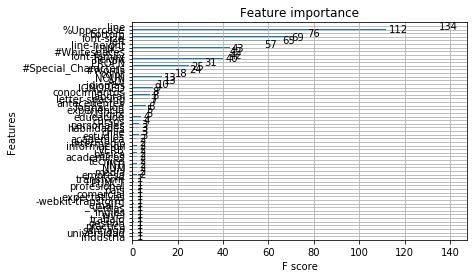

In [22]:
xgb.plot_importance(bst)
plt.rcParams['figure.figsize'] = [15, 15]
plt.show()

In [23]:
#Error evaluation
predictions = bst.predict(xgb.DMatrix(X_test))
def binary_preds(threshold,predictions):
    return [1 if x>threshold else 0 for x in predictions]
thresholds = np.linspace(0,1,num=11)
for t in thresholds:
    print('Treshold: ',t)
    y_pred = binary_preds(t,predictions)
    tn, fp, fn, tp = confusion_matrix(y_test,y_pred).ravel()
    print('true negatives:',tn)
    print('false positives:',fp)
    print('false negatives:',fn)
    print('true positives:',tp)
    print('errors:',fp+fn)
    print()

Treshold:  0.0
true negatives: 0
false positives: 815
false negatives: 0
true positives: 43
errors: 815

Treshold:  0.1
true negatives: 794
false positives: 21
false negatives: 1
true positives: 42
errors: 22

Treshold:  0.2
true negatives: 798
false positives: 17
false negatives: 1
true positives: 42
errors: 18

Treshold:  0.30000000000000004
true negatives: 802
false positives: 13
false negatives: 2
true positives: 41
errors: 15

Treshold:  0.4
true negatives: 805
false positives: 10
false negatives: 3
true positives: 40
errors: 13

Treshold:  0.5
true negatives: 808
false positives: 7
false negatives: 3
true positives: 40
errors: 10

Treshold:  0.6000000000000001
true negatives: 808
false positives: 7
false negatives: 5
true positives: 38
errors: 12

Treshold:  0.7000000000000001
true negatives: 809
false positives: 6
false negatives: 7
true positives: 36
errors: 13

Treshold:  0.8
true negatives: 810
false positives: 5
false negatives: 10
true positives: 33
errors: 15

Treshold:  0

### Summary: The model has out of sample 99.1% AUC-ROC (https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5) which is amazing. Feature importance makes sense, depending on the threshold there are as little as 1.1% error rate and 0.4% false negatives (which means it will not cut the document into a new section when it needs to).

## XGBoost model - Specific cutter: What section is this? https://medium.com/@gabrielziegler3/multiclass-multilabel-classification-with-xgboost-66195e4d9f2d

In [24]:
#First I have to create a single multiclass vector
MULTICLASS = ['Personal_data','Education','Experience','References','Languages','Courses','Other']
specific_label = []
for i in range(len(lb_dat_feats)):
    if lb_dat_feats['section'][i] == 1:
        for j in MULTICLASS: 
            if lb_dat_feats[j][i] == 1:
                specific_label += [MULTICLASS.index(j)+1]
    else:
        specific_label += [0]
lb_dat_feats['specific_label'] = specific_label

In [25]:
#First we'll get the sections
second_stage_drop = ['section','content','Personal_data','Education','Experience','References','Languages','Courses','Other']
second_stage_df = lb_dat_feats.drop(second_stage_drop, axis = 1)
X, y = second_stage_df.drop('specific_label',axis=1),second_stage_df.specific_label
#xgboost doesn't like features starting with '<' or '[' for some unspecified reason
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
X.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X.columns.values]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)
second_stage_dmatrix_train = xgb.DMatrix(data=X_train,label=y_train)
second_stage_dmatrix_test = xgb.DMatrix(data=X_test,label=y_test)

# setup parameters for xgboost
#https://xgboost.readthedocs.io/en/latest/parameter.html
param = {}
# use multiclass loss
param['objective'] = 'multi:softmax'
param['num_class'] = 8
# scale weight of positive examples
#param['scale_pos_weight'] = sum_wneg/sum_wpos
param['eta'] = 0.5 #learning rate
param['max_depth'] = 12 #depth of the trees
param['eval_metric'] = 'merror'
param['colsample_bytree'] = 0.25
param['subsample'] = 0.65

# specify validations set to watch performance
watchlist = [(second_stage_dmatrix_test, 'eval'), (second_stage_dmatrix_train, 'train')]
#boost
num_round = 16
bst_multi = xgb.train(param, second_stage_dmatrix_train, num_round, watchlist)

[0]	eval-merror:0.040793	train-merror:0.041715
[1]	eval-merror:0.029138	train-merror:0.031797
[2]	eval-merror:0.024476	train-merror:0.028005
[3]	eval-merror:0.026807	train-merror:0.026254
[4]	eval-merror:0.024476	train-merror:0.025088
[5]	eval-merror:0.024476	train-merror:0.021295
[6]	eval-merror:0.020979	train-merror:0.021004
[7]	eval-merror:0.020979	train-merror:0.019253
[8]	eval-merror:0.022145	train-merror:0.015753
[9]	eval-merror:0.024476	train-merror:0.013419
[10]	eval-merror:0.024476	train-merror:0.013711
[11]	eval-merror:0.022145	train-merror:0.010793
[12]	eval-merror:0.02331	train-merror:0.01021
[13]	eval-merror:0.022145	train-merror:0.007293
[14]	eval-merror:0.020979	train-merror:0.005834
[15]	eval-merror:0.019814	train-merror:0.004667


### Here we have 1.9% error, which is good considering that there are 8 types of sections. Remember that the broad section cutter had 1.1% error. 

### Next I will try a mixed cutter, I assume that the broad cutter cuts the CV perfectly into sections, and then try to use the combined information from the section (all words and features) and see if I can get an error below 1.9%.

In [26]:
lb_dat_feats.head()

,line,content,section,Personal_data,Education,Experience,References,Languages,Courses,Other,css_t,%Uppercase,%Digits,#Words,#Whitespaces,#Special_Characters,transform,-ms-transform,-webkit-transform,left,height,bottom,font-family,line-height,font-style,font-weight,visibility,font-size,color,text-shadow,letter-spacing,word-spacing,<short_number>,santiago,centro,datos,personales,fecha,nacimiento,marzo,<long_number>,civil,nacionalidad,<email>,estudios,universidad,gerencia,relaciones,instituto,administracion,experiencia,laboral,cargo,gerente,gestion,enero,descripcion,funciones,control,personal,sociales,area,conocimientos,empresa,mensual,encargado,estrategias,evaluacion,cada,realizar,proveedores,servicios,ventas,jefe,noviembre,actividades,pago,intereses,procesos,sistemas,proceso,areas,equipo,trabajo,desarrollo,asistente,septiembre,febrero,manejo,cumplimiento,cartera,analisis,apoyo,venta,cursos,ingles,tecnico,curso,office,internet,banco,habilidades,capacidad,metas,planificacion,sistema,anos,soltero,andes,region,chile,ejecutivo,comercial,mar,profesional,personas,atencion,clientes,productos,seguros,estudio,liceo,empresas,industrial,software,marketing,informacion,negocios,cliente,analista,comerciales,pais,coordinacion,direccion,financiera,contacto,nuevos,ejecutiva,medio,condes,proyectos,mercado,chilena,construccion,responsable,proyecto,san,ingenieria,desempeno,calidad,industria,practica,educacion,servicio,excel,avanzado,power,antecedentes,rut,telefono,laborales,junio,informatica,sql,octubre,nacional,agosto,financieros,tipo,ingeniero,banca,implementacion,general,basica,media,colegio,computacion,ciencias,redes,innovacion,microsoft,trabajar,chilenos,equipos,alto,diciembre,ultima,actualizacion,edad,metropolitana,academicos,ano,egreso,situacion,telemarketing,actividad,telecomunicaciones,desempenos,logros,mayo,compania,nivel,usuario,expectativas,disponibilidad,jornada,completa,pesos,formacion,respuesta,concepcion,ensenanza,intermedio,renta,institucion,academica,si,idiomas,pregunta<short_number>,realizado,<UNK>,ADJ,ADP,ADV,AUX,CCONJ,DET,INTJ,NOUN,NUM,PART,PRON,PROPN,PUNCT,SCONJ,SYM,VERB,X,IGNORED,specific_label
0,0,Adriany Josefina Díaz Gómez,0,0,0,0,0,0,0,0,0.0,0.148148,0.000000,4.0,10.0,0.0,7.0,7.0,7.0,95.424,112.735680,713.02,1.0,1.589369,0.0,0.0,0.0,96.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,1,"Lira 499 con Sta Isabel, Santiago Centro.",0,0,0,0,0,0,0,0,0.0,0.121951,0.073171,7.0,7.0,2.0,7.0,7.0,7.0,198.170,32.789062,696.34,2.0,0.861328,0.0,0.0,0.0,48.00,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [27]:
#Get section features, assume the CV was cut perfectly into sections.
map_list = []
for i in range(len(lb_dat_feats)):
    #Identify beginning line and assign to personal information section if it doesn't have one.
    if lb_dat_feats.iloc[i].line == 0:
        map_list += [max(lb_dat_feats.iloc[i].specific_label,1)]
        current_tag = [1]
    else:
        if lb_dat_feats.iloc[i].specific_label != 0:
            current_tag = [lb_dat_feats.iloc[i].specific_label]
        map_list += current_tag #once we assume first section is personal information 

In [28]:
lb_dat_feats['master_label'] = map_list

In [29]:
# To aggregate the columns and get a feature set for every document (section) I will use the average and sum functions
AVERAGE_LIST = ['line','master_label']+list(FEATURES.columns) #Average positions and percentages
SUM_LIST = POS_TAGS+list(vocab) #sum vocabulary and types of words used
DROP_COLUMNS = first_stage_drop+['section','specific_label']
#Now I need to go row by row aggregating every section. In the end I'll have a labeled documents dataset.
lines_to_docs_df = lb_dat_feats.drop(first_stage_drop+['section','specific_label'],axis=1)
current = lines_to_docs_df.iloc[0].master_label
temp_df = lines_to_docs_df.iloc[0].to_frame().transpose()
flag_exist = True
for i in range(1,len(lines_to_docs_df)):
    if lines_to_docs_df.iloc[i].master_label != current:
        if flag_exist:
            docs_df = pd.concat([temp_df[AVERAGE_LIST].mean().to_frame().transpose(),temp_df[SUM_LIST].sum().to_frame().transpose()],axis=1,sort=False)
            flag_exist = False
        else:
            docs_df = docs_df.append(pd.concat([temp_df[AVERAGE_LIST].mean().to_frame().transpose(),temp_df[SUM_LIST].sum().to_frame().transpose()],axis=1,sort=False))
        #create new temp_df
        temp_df = lines_to_docs_df.iloc[i].to_frame().transpose()
        current = lines_to_docs_df.iloc[i].master_label
    else:
        temp_df = temp_df.append(lines_to_docs_df.iloc[i])
#Last temp_df
docs_df = docs_df.append(pd.concat([temp_df[AVERAGE_LIST].mean().to_frame().transpose(),temp_df[SUM_LIST].sum().to_frame().transpose()],axis=1,sort=False))

In [30]:
X, y = docs_df.drop('master_label',axis=1),docs_df.master_label.apply(lambda x: x-1)
#xgboost doesn't like features starting with '<' or '[' for some unspecified reason
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
X.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X.columns.values]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)
third_stage_dmatrix_train = xgb.DMatrix(data=X_train,label=y_train)
third_stage_dmatrix_test = xgb.DMatrix(data=X_test,label=y_test)
#sum_wpos = len([1 for i in range(len(y_train)) if y_train.reset_index(drop=True)[i] == 1.0])
#sum_wneg = len(y_train) - sum_wpos

# print weight statistics
print ('weight statistics: wpos=%g, wneg=%g, ratio=%g' % ( sum_wpos, sum_wneg, sum_wneg/sum_wpos ))

# setup parameters for xgboost
#https://xgboost.readthedocs.io/en/latest/parameter.html
param = {}
# use multiclass loss
param['objective'] = 'multi:softmax'
param['num_class'] = len(set(docs_df.master_label))
# scale weight of positive examples
#param['scale_pos_weight'] = sum_wneg/sum_wpos
param['eta'] = 0.1 #learning rate
param['max_depth'] = 3 #depth of the trees
param['eval_metric'] = 'merror'
param['colsample_bytree'] = 0.25
param['subsample'] = 0.3

# specify validations set to watch performance
watchlist = [(third_stage_dmatrix_test, 'eval'), (third_stage_dmatrix_train, 'train')]
#boost
num_round = 30
bst_multi = xgb.train(param, third_stage_dmatrix_train, num_round, watchlist)

weight statistics: wpos=172, wneg=3256, ratio=18.9302
[0]	eval-merror:0.478261	train-merror:0.40884
[1]	eval-merror:0.456522	train-merror:0.375691
[2]	eval-merror:0.282609	train-merror:0.276243
[3]	eval-merror:0.304348	train-merror:0.276243
[4]	eval-merror:0.26087	train-merror:0.237569
[5]	eval-merror:0.23913	train-merror:0.243094
[6]	eval-merror:0.26087	train-merror:0.243094
[7]	eval-merror:0.23913	train-merror:0.243094
[8]	eval-merror:0.26087	train-merror:0.237569
[9]	eval-merror:0.282609	train-merror:0.226519
[10]	eval-merror:0.282609	train-merror:0.21547
[11]	eval-merror:0.23913	train-merror:0.209945
[12]	eval-merror:0.282609	train-merror:0.209945
[13]	eval-merror:0.26087	train-merror:0.198895
[14]	eval-merror:0.282609	train-merror:0.160221
[15]	eval-merror:0.282609	train-merror:0.154696
[16]	eval-merror:0.26087	train-merror:0.165746
[17]	eval-merror:0.282609	train-merror:0.143646
[18]	eval-merror:0.282609	train-merror:0.132597
[19]	eval-merror:0.282609	train-merror:0.127072
[20]	e

### An XGBoost model is too complex for a small sample of a little bit more than 200 documents. Naive bayes or multinomial regression may be more appropriate. 

In [31]:
#Naive Bayes Gaussian
X, y = docs_df.drop('master_label',axis=1),docs_df.master_label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of a total %d points using Gaussian Naive Bayes: %d"% (X_test.shape[0], (y_test != y_pred).sum()))
#Naive Bayes Multinomial distribution
mnb = MultinomialNB()
X['letter-spacing'] = X['letter-spacing'].apply(lambda x:x+1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)
y_pred = mnb.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of a total %d points using Multinomial Naive Bayes: %d"% (X_test.shape[0], (y_test != y_pred).sum()))

Number of mislabeled points out of a total 46 points using Gaussian Naive Bayes: 15
Number of mislabeled points out of a total 46 points using Multinomial Naive Bayes: 17


In [32]:
X, y = docs_df.drop('master_label',axis=1),docs_df.master_label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)
# Train multi-class logistic regression model
lr = linear_model.LogisticRegression(solver = 'liblinear',max_iter=1000)
lr.fit(X_train, y_train)
mul_lr = linear_model.LogisticRegression(multi_class='multinomial', solver='newton-cg',max_iter=1000).fit(X_train, y_train)
print("Logistic regression Train Accuracy : ", metrics.accuracy_score(y_train, lr.predict(X_train)))
print("Logistic regression Test Accuracy : ", metrics.accuracy_score(y_test, lr.predict(X_test)))
print("Multinomial Logistic regression Train Accuracy : ", metrics.accuracy_score(y_train, mul_lr.predict(X_train)))
print("Multinomial Logistic regression Test Accuracy : ", metrics.accuracy_score(y_test, mul_lr.predict(X_test)))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Logistic regression Train Accuracy :  1.0
Logistic regression Test Accuracy :  0.7391304347826086
Multinomial Logistic regression Train Accuracy :  1.0
Multinomial Logistic regression Test Accuracy :  0.6521739130434783


In [33]:
#Make naive bayes from the content information only
#Naive Bayes Gaussian
content_word_features = docs_df[list(vocab)+['master_label']]
X, y = content_word_features.drop('master_label',axis=1),content_word_features.master_label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of a total %d points using Gaussian Naive Bayes: %d"% (X_test.shape[0], (y_test != y_pred).sum()))
#Naive Bayes Multinomial distribution
mnb = MultinomialNB()
y_pred = mnb.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of a total %d points using Multinomial Naive Bayes: %d"% (X_test.shape[0], (y_test != y_pred).sum()))

Number of mislabeled points out of a total 46 points using Gaussian Naive Bayes: 16
Number of mislabeled points out of a total 46 points using Multinomial Naive Bayes: 12


### This method wasn't better than the specific cutter using XGBoost in the prior section.

## Once we choose a method fur cutting into sections, it becomes easier to design patterns and apply them to each specific section. For example, a phone number pattern can be used in the 'personal information' section to locate the person's number and in the 'personal references' section to locate the references' numbers.

In [34]:
#Regular expressions for extracting information
RUT_REGEX = re.compile(r'([0-9]{1,2})(((\.\d{3}){2,}\-)|((\d{3}){2,}\-)|((\d{3}){2,}))([\dkK])$')#- ID pattern
MESES = {'enero':1,'febrero':2,'marzo':3,'abril':4,'mayo':5,'junio':6,'julio':7,
         'agosto':8,'septiembre':9,'octubre':10,'noviembre':11,'diciembre':12,
        'january':1,'february':2,'march':3,'april':4,'may':5,'june':6,'july':7,
         'august':8,'september':9,'october':10,'november':11,'december':12}
ESTADO_CIVIL = set(['soltero','soltera','comprometido','comprometida','union libre','separado','separada','divorciado','divorciada'])
set_meses = set(MESES.keys())
CEL_REGEX = re.compile(r'9\d{8}')
EDU_REGEX = re.compile(r"(\b[EUILCT]\w* ?( ?[A-Z]\w*)* ?(de|del)?( ?[A-Z]\w*)+ ?(y)?( ?[A-Z]\w*)*)|(\b([Cc]olegio|[Ll]iceo|[Ii]nstituto) (\w+ ){1,4})")
EDU_CHKLIST = ['escuela','universidad','instituto','liceo','colegio','the','school','university','institute']

with open('paises_gents.json') as f: #File with nationality expressions for every country.
  data = json.load(f)
PAISES_GENTS = []
for key in data.keys():
    PAISES_GENTS += data[key]
PAISES_GENTS = [i for i in PAISES_GENTS if i]
PAISES_GENTS = map(lambda x: unidecode.unidecode(x.lower()),PAISES_GENTS)
PAISES_GENTS = set(PAISES_GENTS)

#There are json files with chilean universities and programs that could be useful, but not universally applied.
data = pd.read_json(r'oferta_educativa.json')
SPAN_EDUCACION = data['AREA CARRERA GENERICA'].tolist()+data['NOMBRE CARRERA'].tolist()+data['NOMBRE TITULO'].tolist()
SPAN_EDUCACION = map(lambda x: unidecode.unidecode(x.lower()),SPAN_EDUCACION)
SPAN_EDUCACION = set(SPAN_EDUCACION)
with open('config.json') as f: #I have a json file with my google custom search engine ID and key (billing has to be allowed the first time)
    data = json.load(f)
SEARCH_ENGINE_ID =  data['se_engine'] 
YEK =  data['key']
REST_FORMAT_URI = 'https://www.googleapis.com/customsearch/v1?'

#Function to validate ID
def validarRut(rut):
    rut = rut.upper();
    rut = rut.replace("-","")
    rut = rut.replace(".","")
    aux = rut[:-1]
    dv = rut[-1:]

    revertido = map(int, reversed(aux))
    factors = cycle(range(2,8))
    s = sum(d * f for d, f in zip(revertido,factors))
    res = (-s)%11
    if str(res) == dv:
        return True

    elif dv=="K" and res==10:
        return True
    else:
        return False

#Gets an ID candidate and validates it
def get_rut(text):
    rut = re.search(RUT_REGEX,text)
    if rut:
        if validarRut(rut[0]):
            return rut[0]
        else:
            return ''
    else:
        return ''
    
#Gets the person's name
def get_name(df):
    #I want a line with at least 2 words in the personal info section
    temp = df[df['master_label']==1][df['#Words']>1]
    ## Sorting variables
    #I want a high proportion of proper nouns
    temp['PROPN/#words'] = temp['PROPN']/(temp['#Words']-temp['IGNORED'])
    #I also want a high proportion of words not in the common vocabulary (i.e. they do not appear in 30% of the CVs)
    temp['UNK/#words'] = (temp['<UNK>']-temp['IGNORED'])/(temp['#Words']-temp['IGNORED'])
    #Special characters are correlated to weird format CVs, so I'd rather drop them.
    temp['Inverse_Special_Chars'] = 1/temp['#Special_Characters']
    #Also, name usually come up first than any other proper nouns. 
    temp['Inverse_line'] = 1/temp['line']
    name = temp.sort_values(by = ['Inverse_Special_Chars','PROPN/#words','UNK/#words','Inverse_line'],ascending=False).iloc[0].content
    return name

#gets the email
def get_email(df):
    temp = df[df['master_label']==1].content
    for text in temp:
        email = re.search(EMAIL_REGEX,x)
        if email:
            return email[0]
    return ''

#gets name
def get_gender(s):
    return detector.guess(s) # => 'male'

#gets birth date
def get_birth_date(df):
    for line in df[(df['master_label']==1) & (df['<short_number>']>0)].content:
        candi_dates = []
        day = False
        clean_contents = pre_proc_string(line,leave_numbers=True)
        buscar_mes_escrito = set(clean_contents.split()).intersection(set_meses)
        flag_mes = False
        if len(buscar_mes_escrito)>0:
            month = list(buscar_mes_escrito)[0]
            flag_mes = True
        else:
            month = False
        year = False
        #The youngest candidate will be 15 years old and the oldest will be 120 years old
        low_limit = date.today().year - 120
        high_limit = date.today().year - 15
        numbers = REG_DIGITS.findall(clean_contents)
        for n in numbers:
            number = int(n)
            if number < high_limit:
                if number<10: #this could be a day or a month
                    candi_dates += [number]
                elif (number>9) and (number<32): #is the two digit number less than 32?
                    if number>12: #This could be an age or a day
                        prior = clean_contents.split()[clean_contents.split().index(n)-1]
                        posterior = clean_contents.split()[clean_contents.split().index(n)+1]
                        if (prior!='edad') and (posterior!='anos'): #if the number is not preceded by 'edad' or followed by 'anos'
                            day = number #we have a two digit number between 13 and 31, this is a day
                    else: #the number is 10,11, or 12
                        candi_dates += [number]
                elif (low_limit < number):
                    year =  number
        if year:
            if (month) and (day):
                if flag_mes:
                     return date(year, MESES[month], day)
                else:
                    return date(year, month, day)
            elif (month) and (len(candi_dates)>0):
                if flag_mes:
                    return date(year, MESES[month], candi_dates[0])
                else:
                    return date(year, month, candi_dates[0])
            elif (day) and (len(candi_dates)>0):
                return date(year, candi_dates[0], day)
            elif len(candi_dates)>1: #I have two possible candidates for date and month, I'm just gonna go with convention dd/mm/yyyy
                return date(year, candi_dates[1], candi_dates[0])
        return None
    
#get phone number
def get_personal_cellphone(df):
    df['long_or_short_digits'] = df['<short_number>']+df['<long_number>']
    for line in df[(df['master_label']==1) & (df['long_or_short_digits']>1)].content.apply(lambda x: pre_proc_string(x,leave_numbers=True).replace(' ','')):
        phone = re.search(CEL_REGEX,line)
        if phone:
            return phone[0]
    return None

def get_country(df):
    temp = df[df['master_label']==1].content
    for line in temp:
        country = list(set(pre_proc_string(line,leave_numbers=True).split()).intersection(PAISES_GENTS))
        if len(country)>0:
            return country[0]
    return None

def get_civil_status(df):
    temp = df[df['master_label']==1].content
    for line in temp:
        status = list(set(pre_proc_string(line,leave_numbers=True).split()).intersection(ESTADO_CIVIL))
        if len(status)>0:
            return status[0]
    return None

def get_info_renta(df):
    return list(df[df['renta']>0].content)

### Personal info was easy, but for the universities and companies we need some sort of entity recognition. The package for NER was useful, but it doesn't work as well in spanish as it does in English, so we'll try an alternative approach.
### The general idea is to get a list of candidates for educacional institutions, using regular expressions that match the way educational institutions are usually written (for example, the first letter might be uppercase, as in UC, Berkeley).

In [35]:
#First we get our entity candidates.
search_list = []
for line in lb_dat_feats[(lb_dat_feats['master_label']==2) & (lb_dat_feats['section']==0)].content.values:
    edu_candidates = re.search(EDU_REGEX,re.sub(r'\W+|_',' ',line.replace('.','')))
    if edu_candidates:
        print(edu_candidates)
        #apply second filter here
        if edu_candidates.group(0).split()[0].isupper() or (any([w.lower() in EDU_CHKLIST for w in edu_candidates.group(0).split()])):
            print(edu_candidates.group(0))
            search_list += [edu_candidates.group(0)]
        print()

<re.Match object; span=(0, 33), match='Universidad Católica Andrés Bello'>
Universidad Católica Andrés Bello

<re.Match object; span=(0, 33), match='Universidad Alejandro de Humboldt'>
Universidad Alejandro de Humboldt

<re.Match object; span=(0, 33), match='Titulo Obtenido Contador Público '>

<re.Match object; span=(0, 53), match='Instituto Universitario de Gerencia y Tecnología >
Instituto Universitario de Gerencia y Tecnología IUGT

<re.Match object; span=(0, 45), match='Título Obtenido TSU Administración y Gerencia'>

<re.Match object; span=(0, 14), match='U de Aconcagua'>
U de Aconcagua

<re.Match object; span=(0, 41), match='Comercio Internacional Exterior Graduado '>

<re.Match object; span=(16, 32), match='Comercio Int Ext'>

<re.Match object; span=(0, 30), match='Universitario Promedio Escala '>

<re.Match object; span=(0, 41), match='CFT Escuela Superior de Comercio Exterior'>
CFT Escuela Superior de Comercio Exterior

<re.Match object; span=(0, 41), match='Comercio Internac

Enseñanza Básica y Media Colegio Carmen Mc Phee Santiago Egreso

<re.Match object; span=(16, 31), match='Estudios Media '>

<re.Match object; span=(0, 41), match='Colegio liceo sta teresita Metropolitana '>
Colegio liceo sta teresita Metropolitana 

<re.Match object; span=(0, 18), match='Títulos Seminarios'>

<re.Match object; span=(0, 40), match='UNIVERSIDAD TÉCNICA FEDERICO SANTA MARIA'>
UNIVERSIDAD TÉCNICA FEDERICO SANTA MARIA

<re.Match object; span=(0, 36), match='Ingeniería Civil Industrial Titulado'>

<re.Match object; span=(23, 41), match='Comercial Titulado'>

<re.Match object; span=(0, 44), match='COLEGIO DE LOS SAGRADOS CORAZONES DE ALAMEDA'>
COLEGIO DE LOS SAGRADOS CORAZONES DE ALAMEDA

<re.Match object; span=(0, 24), match='Educación Básica y Media'>

<re.Match object; span=(22, 39), match='Ingeniería Civil '>

<re.Match object; span=(0, 52), match='Universidad Tecnológica Metropolitana Santiago Ch>
Universidad Tecnológica Metropolitana Santiago Chile

<re.Match object; sp

Instituto de Estudios Bancarios Guillermo Subercaseaux Cursando 

<re.Match object; span=(11, 46), match='Enfermería Enseñanza Media Completa'>

<re.Match object; span=(0, 41), match='Colegio Christian Garden School Práctica '>
Colegio Christian Garden School Práctica 

<re.Match object; span=(5, 22), match='TÍTULO DE ABOGADO'>
TÍTULO DE ABOGADO

<re.Match object; span=(26, 47), match='EN JURISDICCIÓN COMÚN'>
EN JURISDICCIÓN COMÚN

<re.Match object; span=(10, 36), match='UNIVERSIDAD DEL DESARROLLO'>
UNIVERSIDAD DEL DESARROLLO

<re.Match object; span=(14, 43), match='Ciencias Jurídicas y Sociales'>

<re.Match object; span=(5, 24), match='LSI LANGUAGE SCHOOL'>
LSI LANGUAGE SCHOOL

<re.Match object; span=(38, 63), match='California Estados Unidos'>

<re.Match object; span=(10, 35), match='COLEGIO SSCC DE MANQUEHUE'>
COLEGIO SSCC DE MANQUEHUE

<re.Match object; span=(0, 24), match='Educación Básica y Media'>

<re.Match object; span=(0, 20), match='Universidad Católica'>
Universidad Católic

Escuela de Negocios 

<re.Match object; span=(0, 20), match='Ingeniero Comercial '>

<re.Match object; span=(14, 41), match='Ciencias de Administración '>

<re.Match object; span=(62, 70), match='Univ UAI'>

<re.Match object; span=(0, 25), match='Estudios Medios y Básicos'>

<re.Match object; span=(10, 47), match='COLEGIO SAINT MARGARET S Viña del Mar'>
COLEGIO SAINT MARGARET S Viña del Mar

<re.Match object; span=(0, 40), match='Idiomas Inglés Avanzado Portugués Básico'>

<re.Match object; span=(16, 31), match='Estudios Media '>

<re.Match object; span=(0, 33), match='Colegio liceo max salas marchant '>
Colegio liceo max salas marchant 

<re.Match object; span=(0, 31), match='EXPERIENCIA LABORAL E INTERESES'>
EXPERIENCIA LABORAL E INTERESES

<re.Match object; span=(10, 30), match='Laboral Sin Trabajo '>

<re.Match object; span=(7, 28), match='Empresa V Valparaíso '>

<re.Match object; span=(17, 43), match='Computación Nivel Usuario '>



### Next, we use this candidate list to make queries in the google search API, and then collect the snippets to make some NLP analysis on them and separate entities from other information. 

In [36]:
query_result =[]
for query in search_list:
    full_url = REST_FORMAT_URI + 'key=' + YEK + '&cx=' + SEARCH_ENGINE_ID + '&q=' + query + '&lr=lang_es'
    r = requests.get(full_url)
    contents = ''
    for item in r.json()['items']:
        try:
            contents = contents + item['snippet'].replace('\n','')
        except KeyError:
            continue
    query_result += [(query,contents)]
    time.sleep(1)
query_result

[('Universidad Católica Andrés Bello',
  'El Consejo Universitario emitió un comunicado en el que aseguró que la ACFIMAN ejerció sus atribuciones legales al alertar, mediante un informe técnico,\xa0...La Universidad Católica Andrés Bello (UCAB), conocida como «La Católica», es una universidad privada con sede en Caracas, Venezuela. Es miembro de la\xa0...58.8k Posts - See Instagram photos and videos taken at \'Universidad Católica Andrés Bello\'Learn more about studying at Universidad Católica Andres Bello including how it performs in QS rankings, the cost of tuition and further course information.The purpose of IIC\'s participation is to improve the risk profile of the transaction and to help Fundación Andrés Bello obtain financing under better terms and\xa0...Founded in 1953, Universidad Católica Andres Bello (Andres Bello Catholic University) is a private higher education institution located in the urban setting of the\xa0...3 Abr 2019 ... The fifth Discusiones lecture series will s

In [37]:
#Let's save this file so we can add the labels manually. 
with open('edu_candidates.csv','w',encoding='UTF-8') as f:
    file = csv.writer(f)
    for row in query_result:
        file.writerow(row)

In [38]:
#Now take the labeled dataset and classify using XGBoost or naive bayes
edu_labeled_dataset = pd.read_csv('edu_candidates_labeled.csv')
words = []
#Preprocessing
for i in range(len(edu_labeled_dataset)):
    for s in edu_labeled_dataset.iloc[i,2].split(' '):
        clean_s = pre_proc_string(s)
        if len(clean_s):
            words += [word for word in clean_s.split(' ') if word not in IGNORE and len(word)>1] #there are some single letters appearing in the vocabulary
vocab = Vocabulary(words,unk_cutoff=10) 

In [39]:
print(sorted(vocab))
print(len(vocab))

['<UNK>', '<email>', '<long_number>', '<short_number>', '<short_number>k', 'about', 'abr', 'abril', 'academica', 'academico', 'academicos', 'acceso', 'account', 'aconcagua', 'acreditacion', 'acreditada', 'actividades', 'administracion', 'administrativas', 'admision', 'adolfo', 'adultos', 'ago', 'aiep', 'alameda', 'alberto', 'alejandro', 'alexander', 'alumnos', 'ambiente', 'america', 'americas', 'an', 'analisis', 'and', 'andes', 'andres', 'ano', 'anos', 'antofagasta', 'aqui', 'are', 'areas', 'arquitectura', 'artes', 'arturo', 'asi', 'at', 'atencion', 'augusto', 'autonoma', 'autoridades', 'av', 'avenida', 'bachillerato', 'bachilleratos', 'bajo', 'base', 'based', 'basica', 'basico', 'beca', 'becas', 'been', 'bello', 'bernardo', 'bi', 'bibliotecas', 'bienvenido', 'bienvenidos', 'bio', 'british', 'buenos', 'busca', 'business', 'by', 'cada', 'calidad', 'calificacion', 'camilo', 'campus', 'cancel', 'carmela', 'carrera', 'carreras', 'carvajal', 'casa', 'castro', 'catolica', 'central', 'centro'

In [40]:
def generate_bow(text,vocab,ignore):
    #This function generates the bag of words for the naive bayes model. 
    v = np.zeros(len(vocab))
    words = []
    for w in text.split(' '):
        clean_w = pre_proc_string(w)
        if len(clean_w):
            v[list(vocab).index(vocab.lookup(clean_w))] += 1
    return np.asarray(v)

In [41]:
%%time
#Apply for all lines
first = True
for i in range(len(edu_labeled_dataset)):
    if first:
        sparse_matrix = generate_bow(edu_labeled_dataset.iloc[i,2],vocab,IGNORE)
        first = False
    else:
        sparse_matrix = np.vstack((sparse_matrix,generate_bow(edu_labeled_dataset.iloc[i,2],vocab,IGNORE)))
cols = list(vocab)
feats_words = pd.DataFrame(sparse_matrix,columns = cols)
feats_words.head()

Wall time: 3min 18s


,consejo,universitario,mediante,tecnico,universidad,catolica,andres,bello,privada,sede,venezuela,<short_number>k,posts,see,instagram,and,videos,at,learn,more,about,it,in,the,of,information,is,to,fundacion,founded,<short_number>,university,private,education,institution,located,abr,centro,padre,guillermo,info,historia,social,perfil,avenida,ciudad,base,alejandro,humboldt,institucion,privado,civil,educativa,was,alexander,asi,cientifico,formar,profesionales,mas,calidad,dos,gusta,personas,estan,hablando,from,oficial,cuenta,linkedin,hoy,likes,talking,this,were,here,iugt,informatica,comercial,recursos,instituto,gerencia,tecnologia,educativo,administracion,experiencia,trabajo,international,director,general,alberto,aconcagua,carreras,tecnicas,estudios,postgrados,gestion,consulta,academica,plan,titulo,chilena,autonoma,regional,anos,may,followers,on,following,chile,informacion,futuro,profesional,digital,institucional,servicio,mision,vision,superior,autoridades,cft,escuela,comercio,exterior,formacion,tecnica,alumnos,professional,ip,santiago,nivel,oct,carrera,docencia,ingenieria,titulos,datos,valparaiso,actividades,nov,estudio,profesor,club,liceo,mixto,chileno,andes,fundado,ano,mayor,particular,busca,facebook,basica,are,english,espanol,sep,silva,loading,unsubscribe,cancel,working,disciplina,sedes,san,jul,uc,francisco,colegio,curso,americas,ofrece,primera,programas,telefono,<email>,acreditada,estudia,becas,av,quito,menu,puebla,mejor,educacion,mexico,ubicada,acceso,udla,ecuador,<long_number>,bienvenidos,forma,ingles,mundo,hace,economico,insec,puerto,mejores,contacto,servicios,empresas,nombre,empresa,veterinario,mar,desarrollo,vina,cl,beca,estudiantes,perteneciente,grupo,universidades,diplomados,clases,join,today,academicos,campus,diego,portales,magister,proyectos,online,dia,atencion,fundada,directorio,ruben,castro,abril,calificacion,segun,opiniones,dentro,ranking,rated,based,reviews,buenos,departamento,ciencias,realizo,out,sitio,web,ago,school,tres,sur,conjunto,objetivo,obtener,excelencia,fecha,niveles,ve,direccion,inicio,valores,concepcion,chillan,jun,total,comunicacion,sistemas,computacion,universitarios,programacion,profesion,derecho,analisis,grado,licenciado,ingeniero,certificado,internacional,todas,escuelas,programa,pregrado,college,medicina,areas,artes,salud,universitaria,postgrado,red,centros,arquitectura,diseno,ejecucion,acreditacion,parte,bio,software,lagos,proceso,osorno,aqui,proyecto,investigacion,region,academico,for,free,who,you,know,master,an,bajo,new,nacional,ciclo,portal,unab,admision,traves,sistema,bibliotecas,talleres,cursos,media,many,translated,example,sentences,containing,spanish,dictionary,search,engine,translations,inteligencia,negocios,herramientas,business,bi,procesos,tecnologias,permite,ene,cada,medio,maria,profesora,linea,gran,conoce,especializada,facultad,requerimientos,dic,comunidad,primer,fines,conocimiento,tambien,practica,vida,feb,modelo,ley,seguridad,puede,ensenanza,virtual,laboral,colombia,docente,internado,si,solida,iacc,noticias,nueva,innovacion,publica,coronavirus,valdivia,independencia,arturo,prat,casa,central,nuevo,economicas,administrativas,santo,jose,ir,unidad,pontificia,pais,economia,duoc,leverage,your,ruiz,tagle,christian,escolar,connect,with,people,gonzalez,hurtado,colegios,educacional,valenzuela,carmela,metropolitana,imparte,certificados,establecimiento,basico,junto,santa,secundaria,bachillerato,bienvenido,indigena,home,postulacion,humanista,reino,like,tecnologica,egresados,diplomado,subercaseaux,over,sagrado,corazon,udd,camilo,gomez,juridicas,providencia,molina,conocimientos,federico,usm,sagrados,corazones,alameda,log,or,create,account,sebastian,montt,finis,terrae,facultades,by,primaria,grados,verbo,germania,divino,condes,its,aiep,bernardo,marin,adultos,politecnico,melipilla,mercedes,polivalente,solar,henriquez,sek,augusto,santelices,valle,industrial,ambiente,plus,uai,adolfo,ibanez,bachilleratos,half,century,tradition,been,garden,cruz,jurisdiccion,salas,language,british,manquehue,america,antofagas

### Now we will take the sparse matrix from the google search and use a naive bayes model to predict whether the query was an educational institution or information we are not interested in extracting.

In [42]:
#small XGBoost
X, y = feats_words,edu_labeled_dataset['Label']
#xgboost doesn't like features starting with '<' or '[' for some unspecified reason
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
X.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X.columns.values]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)
edu_dmatrix_train = xgb.DMatrix(data=X_train,label=y_train)
edu_dmatrix_test = xgb.DMatrix(data=X_test,label=y_test)
sum_wpos = len([1 for i in range(len(y_train)) if y_train.reset_index(drop=True)[i] == 1.0])
sum_wneg = len(y_train) - sum_wpos

# print weight statistics
print ('weight statistics: wpos=%g, wneg=%g, ratio=%g' % ( sum_wpos, sum_wneg, sum_wneg/sum_wpos ))

# setup parameters for xgboost
#https://xgboost.readthedocs.io/en/latest/parameter.html
param = {}
# use logistic regression loss
param['objective'] = 'binary:logistic'
# scale weight of positive examples
param['scale_pos_weight'] = sum_wneg/sum_wpos
param['eta'] = 0.5 #learning rate
param['max_depth'] = 3 #depth of the trees
param['eval_metric'] = 'error'
param['colsample_bytree'] = 0.25 #columns by tree
param['subsample'] = 0.65 #sample in each round

# specify validations set to watch performance
watchlist = [(edu_dmatrix_test, 'eval'), (edu_dmatrix_train, 'train')]
#boost 
num_round = 10
bst = xgb.train(param, edu_dmatrix_train, num_round, watchlist)

weight statistics: wpos=93, wneg=42, ratio=0.451613
[0]	eval-error:0.264706	train-error:0.222222
[1]	eval-error:0.205882	train-error:0.207407
[2]	eval-error:0.088235	train-error:0.133333
[3]	eval-error:0.058824	train-error:0.111111
[4]	eval-error:0.088235	train-error:0.111111
[5]	eval-error:0.088235	train-error:0.118519
[6]	eval-error:0.058824	train-error:0.074074
[7]	eval-error:0.029412	train-error:0.081481
[8]	eval-error:0.029412	train-error:0.074074
[9]	eval-error:0.029412	train-error:0.081481


### 2.9% error, not bad for a method that will try to get every educational institution from the CV. 

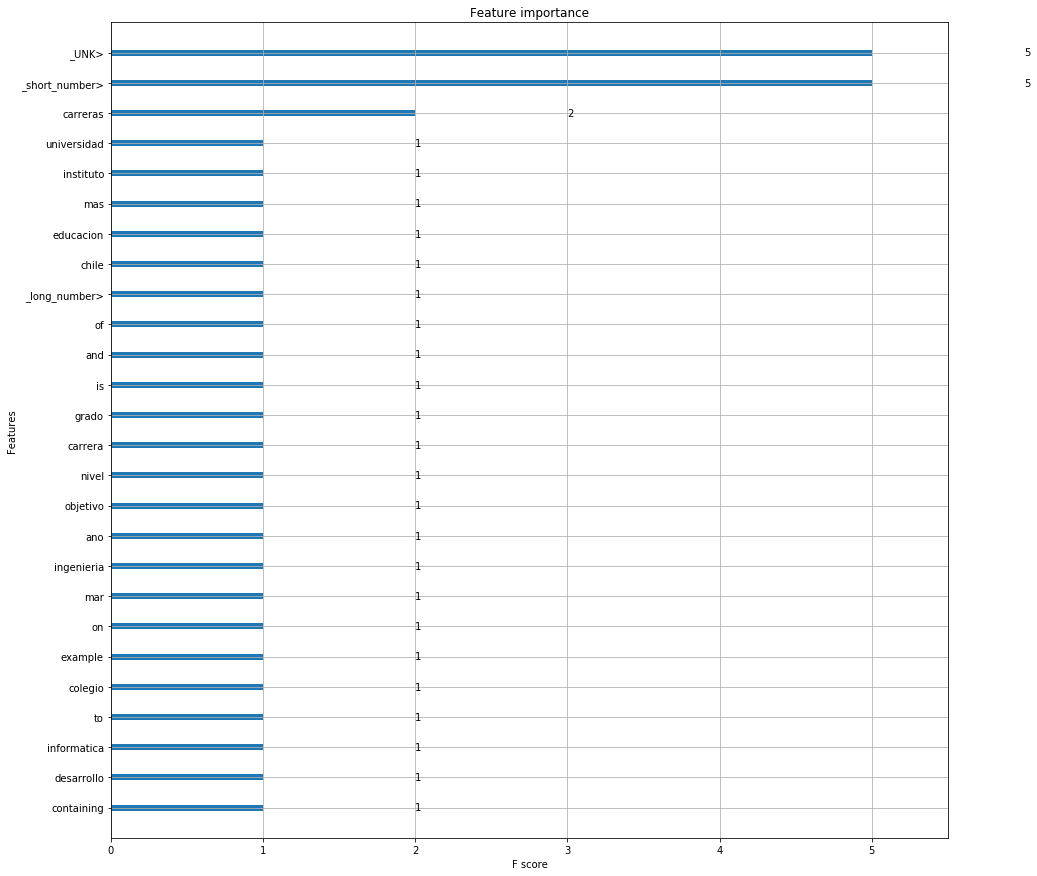

In [43]:
xgb.plot_importance(bst)
plt.rcParams['figure.figsize'] = [15, 15]
plt.show()

In [44]:
#Naive Bayes Gaussian
X, y = feats_words,edu_labeled_dataset['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of a total %d points using Gaussian Naive Bayes: %d"% (X_test.shape[0], (y_test != y_pred).sum()))

Number of mislabeled points out of a total 34 points using Gaussian Naive Bayes: 9


### XGBoost worked better than naive bayes to separate entities from other information using the google search snippets for each candidate term.

# Summary: This notebook presents methods for extracting information from a CV. First we want to transform the document to HTML to get the rich tag data and formatting information to add a further dimension to text analysis.
# Then, we want to cut the document into sections, an XGBoost model works very well here and it's useful to identify where a new section begins and what type it is. 
# Having the sections it's relatively easy to design patterns that match the info we're looking for in each section. That said, some entity recognition is needed to extract universities, schools and companies (in the experience section). This notebook proposes a method to get entity candidates, and then check whether the google search snippets for each candidate are consistent with those of an entity or a different term. This method solves the underperfomance of the Named Entity Recognition tagger from the Stanford NLP package for spanish. It is likely that the sample on which the NER was trained (press reports) leaves the program at a loss when confronted to a CV context.